In [9]:
import pandas as pd

# 读取数据
df = pd.read_csv('Orders_merged.csv', parse_dates=['order_purchase_timestamp'])

# 1. 计算去重后的客户数、总交易金额、客单价
user_count = df['customer_id'].nunique()  # 去重客户数
total_amount = df['payment_value'].sum()
customer_unit_price = total_amount / user_count
print(f"去重客户数: {user_count}, 总交易金额: {total_amount:.2f}, 客单价: {customer_unit_price:.2f}")

# 2. 计算订单量、笔单价
order_count = df['order_id'].nunique()  # 去重订单数
order_unit_price = total_amount / order_count
print(f"订单量: {order_count}, 笔单价: {order_unit_price:.2f}")

# 3. 近两年趋势分析（去重统计）
df['year'] = df['order_purchase_timestamp'].dt.year
recent_years = df['year'].max() - 1
df_recent = df[df['year'] >= recent_years]

trend = df_recent.groupby('year').agg({
    'customer_id': pd.Series.nunique,  # 去重客户数
    'payment_value': 'sum',
    'seller_id': pd.Series.nunique     # 去重商家数
}).rename(columns={
    'customer_id': '客户数',
    'payment_value': '交易金额',
    'seller_id': '商家数'
})
print(trend)

去重客户数: 96478, 总交易金额: 15170437.55, 客单价: 157.24
订单量: 96478, 笔单价: 157.24
        客户数        交易金额   商家数
year                         
2017  43428  6798411.07  1683
2018  52783  8325970.45  2317


数据加载成功，共96211条记录

基础业务指标:
去重客户数: 93104
总交易金额: 15124381.52
客单价(总金额/去重客户数): 162.45
订单量: 96211
笔单价(总金额/订单数): 157.20

近2年业务趋势:
        客户数       交易金额   商家数    订单数  客户数增长率  交易金额增长率  商家数增长率  订单数增长率
year                                                                
2017  42136 6798411.07  1683  43428     NaN      NaN     NaN     NaN
2018  51612 8325970.45  2317  52783    0.22     0.22    0.38    0.22
趋势图表已保存为 business_trends.png


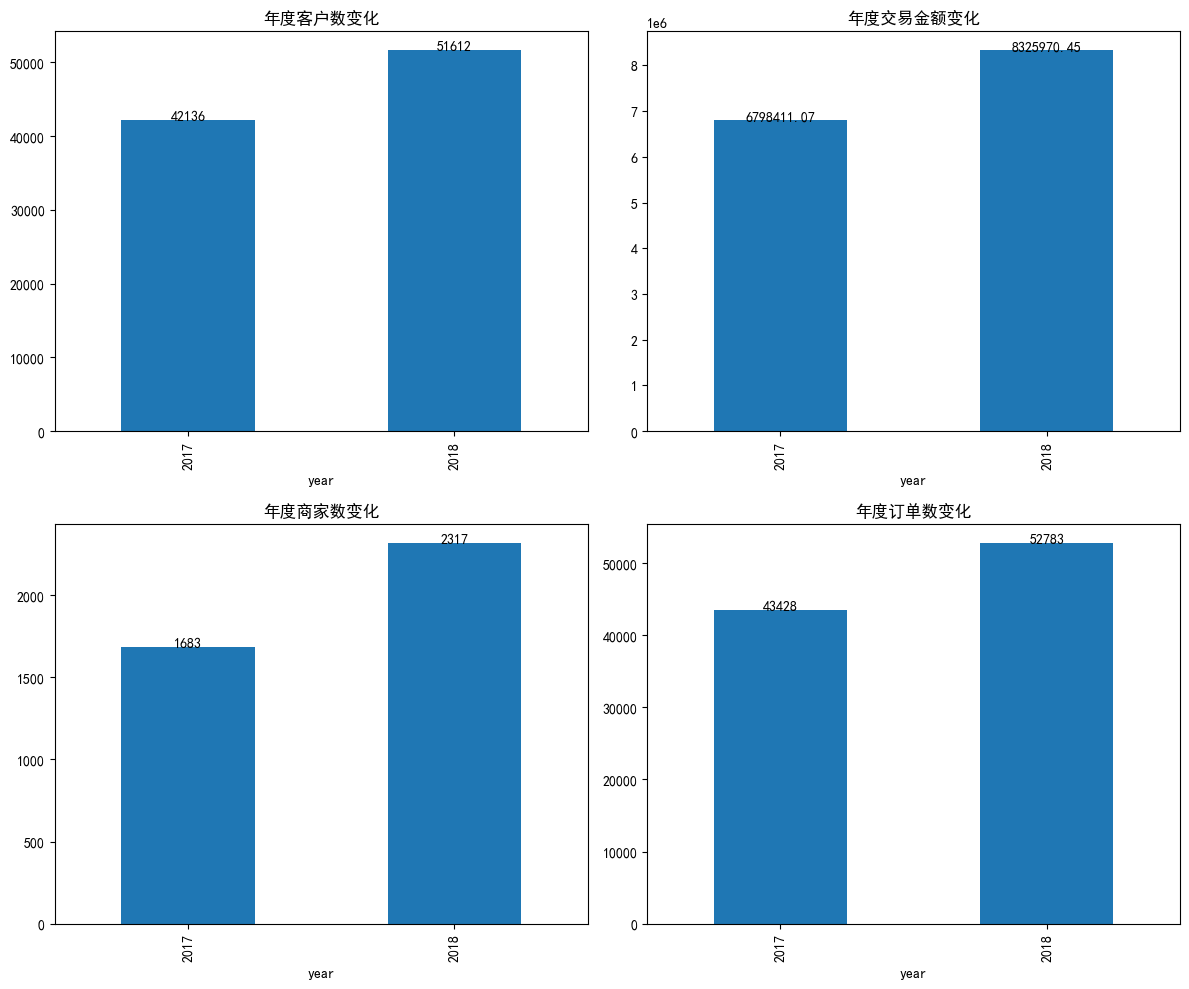

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
def load_data(file_path: str) -> pd.DataFrame:
    """加载并预处理数据"""
    try:
        df = pd.read_csv(file_path, parse_dates=['下单时间'])
        print(f"数据加载成功，共{len(df)}条记录")
        return df
    except FileNotFoundError:
        print(f"错误：文件 '{file_path}' 不存在")
        return pd.DataFrame()
    except Exception as e:
        print(f"数据加载错误: {e}")
        return pd.DataFrame()

def calculate_basic_metrics(df: pd.DataFrame) -> Tuple[int, float, float, int, float]:
    """计算基础业务指标"""
    if df.empty:
        return 0, 0.0, 0.0, 0, 0.0
    
    # 计算客户相关指标
    user_count = df['客户唯一ID'].nunique()
    total_amount = df['支付金额'].sum()
    
    # 客单价计算逻辑：总金额/去重客户数
    customer_unit_price = total_amount / user_count if user_count > 0 else 0
    
    # 计算订单相关指标
    order_count = df['订单ID'].nunique()
    order_unit_price = total_amount / order_count if order_count > 0 else 0
    
    return user_count, total_amount, customer_unit_price, order_count, order_unit_price

def analyze_recent_trends(df: pd.DataFrame, years: int = 2) -> Optional[pd.DataFrame]:
    """分析近n年的业务趋势"""
    if df.empty:
        return None
    
    # 提取年份信息
    df['year'] = df['下单时间'].dt.year
    
    # 计算最近几年
    max_year = df['year'].max()
    recent_years = list(range(max_year - years + 1, max_year + 1))
    
    # 筛选最近几年的数据
    df_recent = df[df['year'].isin(recent_years)]
    
    # 按年分组统计
    trend = df_recent.groupby('year').agg({
        '客户唯一ID': pd.Series.nunique,
        '支付金额': 'sum',
        '卖家ID': pd.Series.nunique,
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '客户唯一ID': '客户数',
        '支付金额': '交易金额',
        '卖家ID': '商家数',
        '订单ID': '订单数'
    })
    
    # 计算增长率
    for col in ['客户数', '交易金额', '商家数', '订单数']:
        trend[f'{col}增长率'] = trend[col].pct_change()
    
    return trend

def visualize_trends(trend: pd.DataFrame) -> None:
    """可视化趋势分析结果"""
    if trend is None or trend.empty:
        print("没有趋势数据可可视化")
        return
    
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 客户数趋势
    trend['客户数'].plot(kind='bar', ax=axes[0, 0], title='年度客户数变化')
    for i, v in enumerate(trend['客户数']):
        axes[0, 0].text(i, v + 10, f'{v}', ha='center')
    
    # 交易金额趋势
    trend['交易金额'].plot(kind='bar', ax=axes[0, 1], title='年度交易金额变化')
    for i, v in enumerate(trend['交易金额']):
        axes[0, 1].text(i, v + 1000, f'{v:.2f}', ha='center')
    
    # 商家数趋势
    trend['商家数'].plot(kind='bar', ax=axes[1, 0], title='年度商家数变化')
    for i, v in enumerate(trend['商家数']):
        axes[1, 0].text(i, v + 1, f'{v}', ha='center')
    
    # 订单数趋势
    trend['订单数'].plot(kind='bar', ax=axes[1, 1], title='年度订单数变化')
    for i, v in enumerate(trend['订单数']):
        axes[1, 1].text(i, v + 10, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('business_trends.png')
    print("趋势图表已保存为 business_trends.png")

def main():
    """主函数，执行完整分析流程"""
    file_path = '../Orders_merged_zh_cleaned_2017-2018.csv'
    
    # 加载数据
    df = load_data(file_path)
    if df.empty:
        return
    
    # 计算基础指标
    user_count, total_amount, customer_unit_price, order_count, order_unit_price = calculate_basic_metrics(df)
    print("\n基础业务指标:")
    print(f"去重客户数: {user_count}")
    print(f"总交易金额: {total_amount:.2f}")
    print(f"客单价(总金额/去重客户数): {customer_unit_price:.2f}")
    print(f"订单量: {order_count}")
    print(f"笔单价(总金额/订单数): {order_unit_price:.2f}")
    
    # 分析趋势
    trend = analyze_recent_trends(df, years=2)
    if trend is not None:
        print("\n近2年业务趋势:")
        print(trend.to_string(float_format='{:.2f}'.format))
        
        # 可视化趋势
        visualize_trends(trend)

if __name__ == "__main__":
    main()

数据加载成功，共96211条记录

基础业务指标:
去重客户数: 93104
总交易金额: 15124381.52
客单价(总金额/去重客户数): 162.45
订单量: 96211
笔单价(总金额/订单数): 157.20

近2年业务趋势:
        客户数       交易金额   商家数    订单数  客户数增长率  交易金额增长率  商家数增长率  订单数增长率
year                                                                
2017  42136 6798411.07  1683  43428     NaN      NaN     NaN     NaN
2018  51612 8325970.45  2317  52783    0.22     0.22    0.38    0.22
趋势图表已保存为 business_trends.png
季度分析图表已保存为 quarterly_sales.png

季度交易分析结果:
交易金额最高的季度: 2018Q2，金额为 3224589.24 元
订单量最高的季度: 2018Q1，订单量为 20627
月度分析图表已保存为 monthly_sales.png

月度交易分析结果:
交易金额最高的月份: 2017-11，金额为 1138352.92 元，环比增长率为 54.11%
该月订单量: 7289
2017年11月每日分析图表已保存为 november_2017_daily.png

2017年11月每日交易分析结果:
交易金额最高的日期: 11月24.0日，金额为 173894.10 元
订单量最高的日期: 11月24.0日，订单量为 1147.0
注意: 11月24日是黑色星期五，这可能是销量激增的原因之一


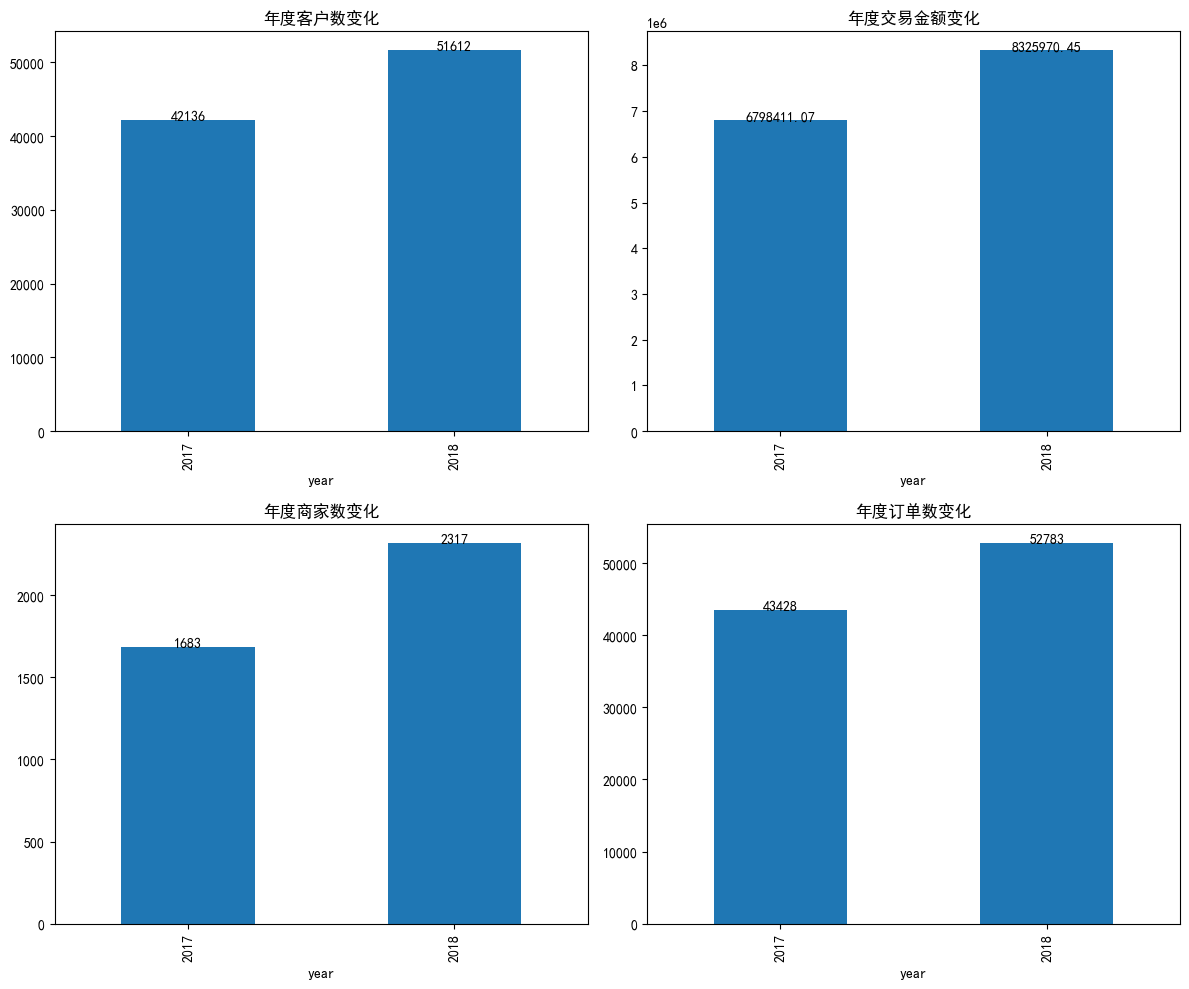

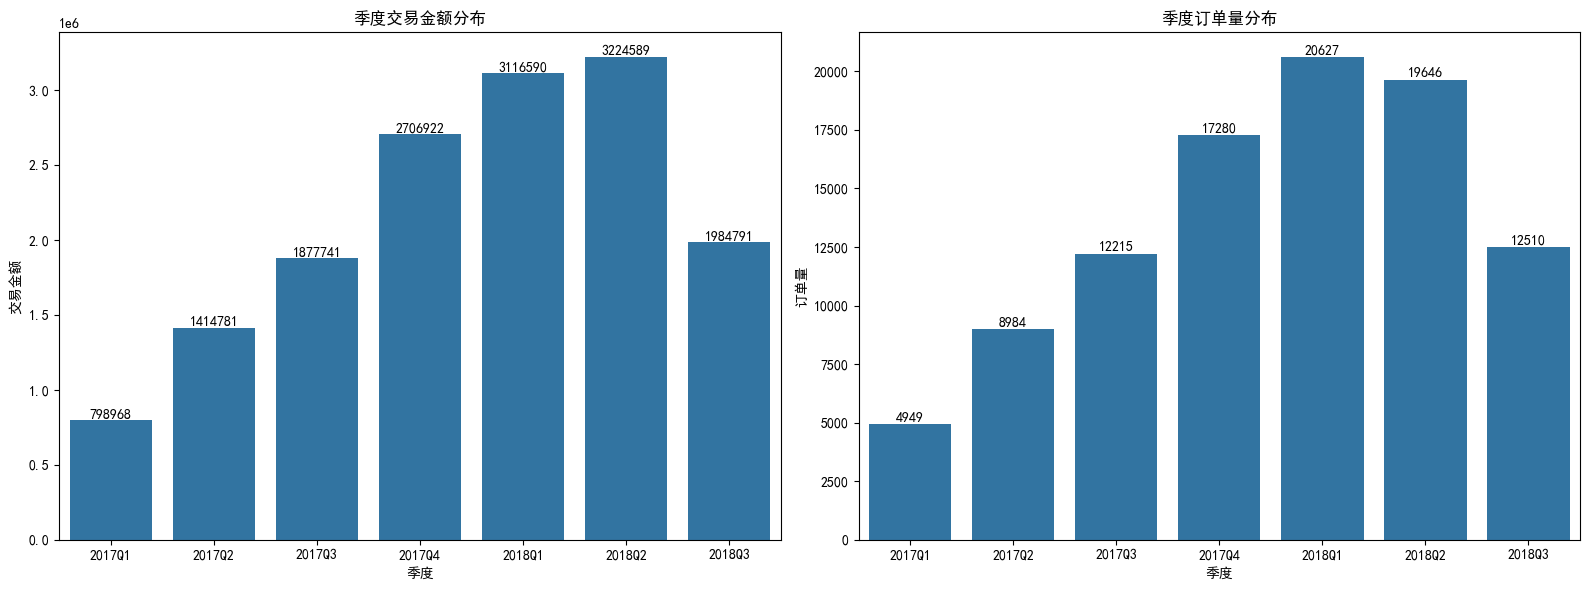

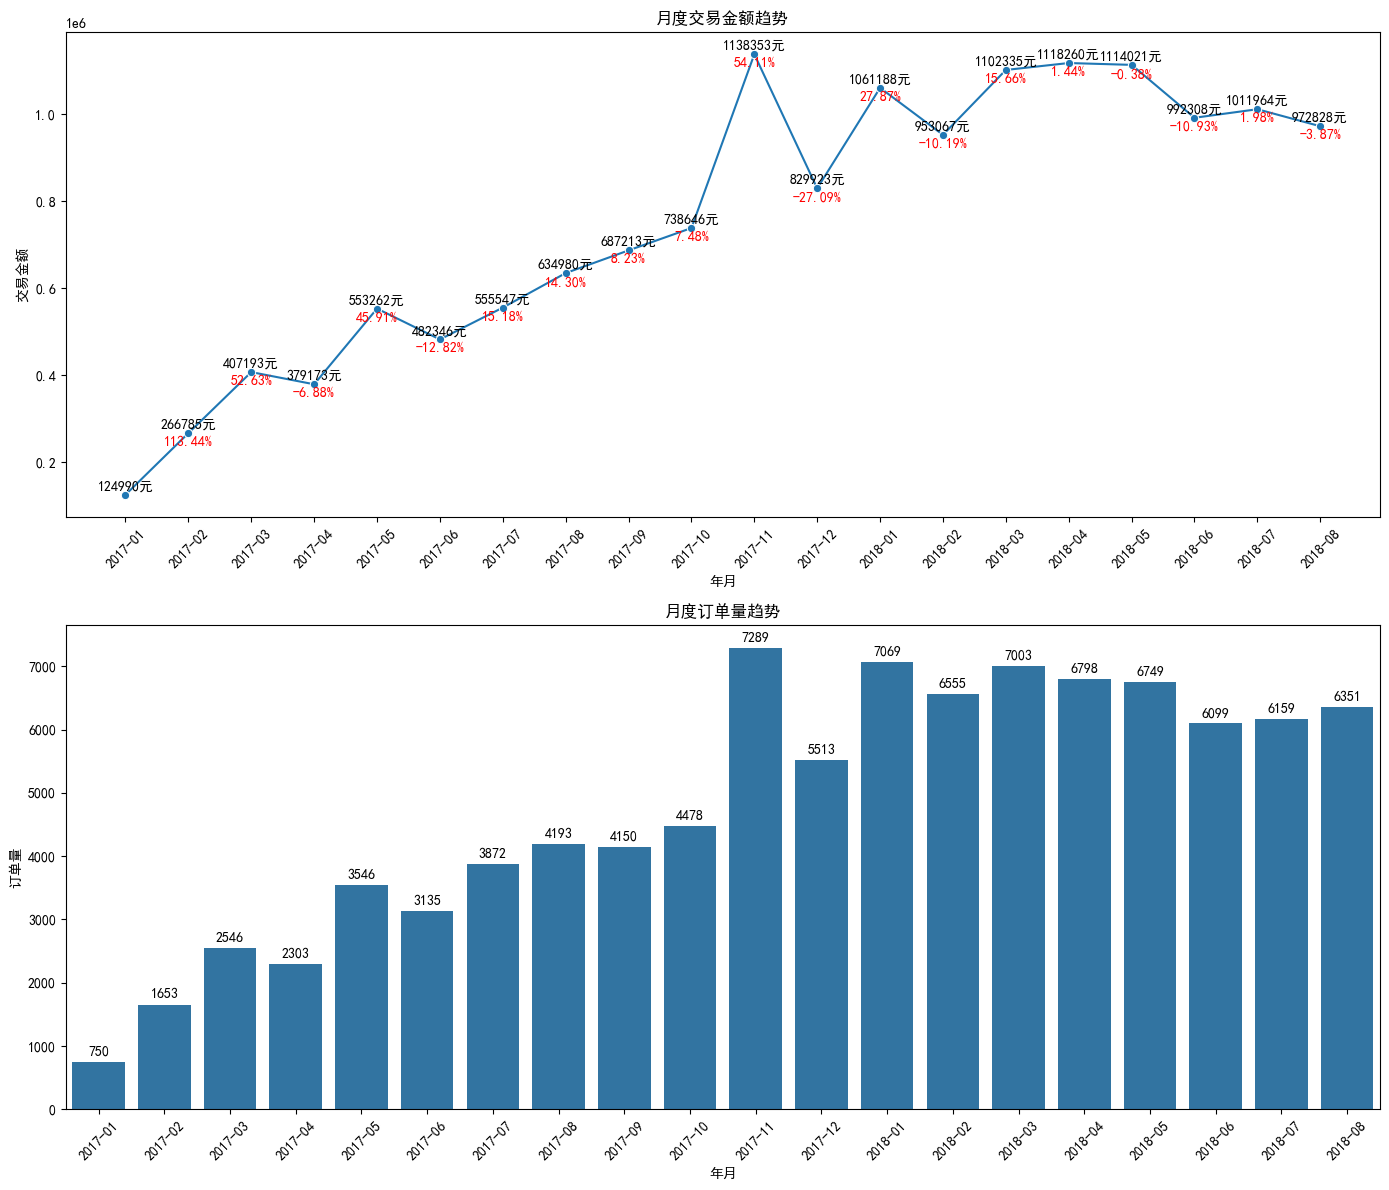

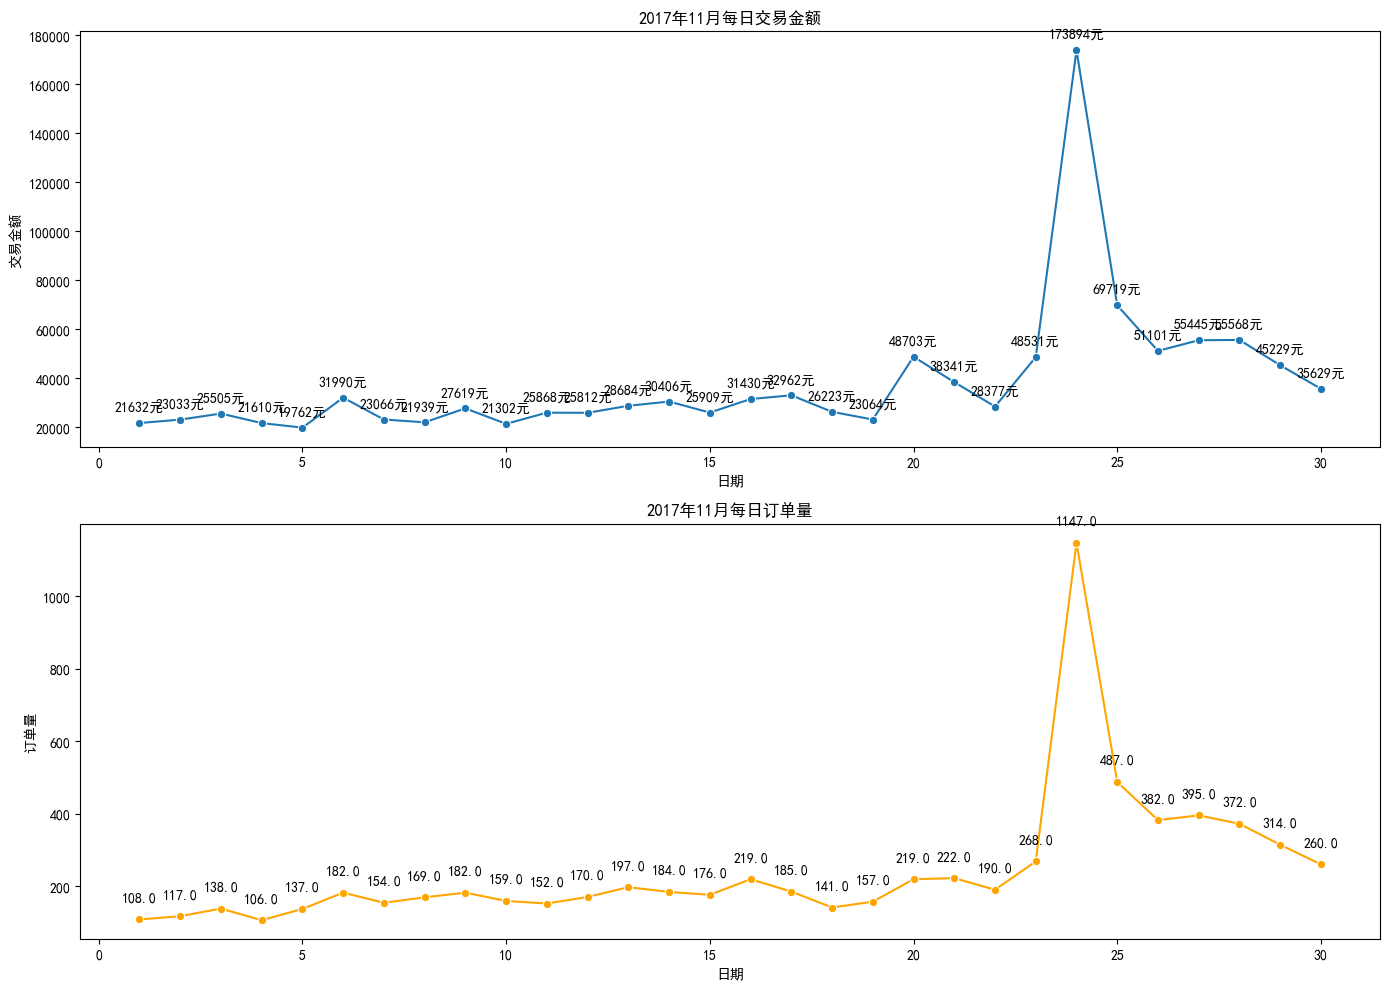

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def load_data(file_path: str) -> pd.DataFrame:
    """加载并预处理数据"""
    try:
        df = pd.read_csv(file_path, parse_dates=['下单时间'])
        print(f"数据加载成功，共{len(df)}条记录")
        return df
    except FileNotFoundError:
        print(f"错误：文件 '{file_path}' 不存在")
        return pd.DataFrame()
    except Exception as e:
        print(f"数据加载错误: {e}")
        return pd.DataFrame()

def calculate_basic_metrics(df: pd.DataFrame) -> Tuple[int, float, float, int, float]:
    """计算基础业务指标"""
    if df.empty:
        return 0, 0.0, 0.0, 0, 0.0
    
    # 计算客户相关指标
    user_count = df['客户唯一ID'].nunique()
    total_amount = df['支付金额'].sum()
    
    # 客单价计算逻辑：总金额/去重客户数
    customer_unit_price = total_amount / user_count if user_count > 0 else 0
    
    # 计算订单相关指标
    order_count = df['订单ID'].nunique()
    order_unit_price = total_amount / order_count if order_count > 0 else 0
    
    return user_count, total_amount, customer_unit_price, order_count, order_unit_price

def analyze_recent_trends(df: pd.DataFrame, years: int = 2) -> Optional[pd.DataFrame]:
    """分析近n年的业务趋势"""
    if df.empty:
        return None
    
    # 提取年份信息
    df['year'] = df['下单时间'].dt.year
    
    # 计算最近几年
    max_year = df['year'].max()
    recent_years = list(range(max_year - years + 1, max_year + 1))
    
    # 筛选最近几年的数据
    df_recent = df[df['year'].isin(recent_years)]
    
    # 按年分组统计
    trend = df_recent.groupby('year').agg({
        '客户唯一ID': pd.Series.nunique,
        '支付金额': 'sum',
        '卖家ID': pd.Series.nunique,
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '客户唯一ID': '客户数',
        '支付金额': '交易金额',
        '卖家ID': '商家数',
        '订单ID': '订单数'
    })
    
    # 计算增长率
    for col in ['客户数', '交易金额', '商家数', '订单数']:
        trend[f'{col}增长率'] = trend[col].pct_change()
    
    return trend

def analyze_quarterly_sales(df: pd.DataFrame) -> None:
    """分析季度交易情况"""
    if df.empty:
        print("没有数据可用于季度分析")
        return
    
    # 提取季度信息
    df['quarter'] = df['下单时间'].dt.to_period('Q')
    
    # 按季度分组统计
    quarterly_data = df.groupby('quarter').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 将Period类型转换为字符串以便绘图
    quarterly_data['quarter_str'] = quarterly_data['quarter'].astype(str)
    
    # 创建图表
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 季度交易金额柱状图
    sns.barplot(x='quarter_str', y='交易金额', data=quarterly_data, ax=axes[0])
    axes[0].set_title('季度交易金额分布')
    axes[0].set_xlabel('季度')
    axes[0].set_ylabel('交易金额')
    for i, v in enumerate(quarterly_data['交易金额']):
        axes[0].text(i, v + 10000, f'{v:.0f}', ha='center', rotation=0)
    
    # 季度订单量柱状图
    sns.barplot(x='quarter_str', y='订单量', data=quarterly_data, ax=axes[1])
    axes[1].set_title('季度订单量分布')
    axes[1].set_xlabel('季度')
    axes[1].set_ylabel('订单量')
    for i, v in enumerate(quarterly_data['订单量']):
        axes[1].text(i, v + 100, f'{v}', ha='center', rotation=0)
    
    plt.tight_layout()
    plt.savefig('quarterly_sales.png')
    print("季度分析图表已保存为 quarterly_sales.png")
    
    # 打印分析结果
    max_quarter_amount = quarterly_data.loc[quarterly_data['交易金额'].idxmax()]
    max_quarter_orders = quarterly_data.loc[quarterly_data['订单量'].idxmax()]
    
    print("\n季度交易分析结果:")
    print(f"交易金额最高的季度: {max_quarter_amount['quarter_str']}，金额为 {max_quarter_amount['交易金额']:.2f} 元")
    print(f"订单量最高的季度: {max_quarter_orders['quarter_str']}，订单量为 {max_quarter_orders['订单量']}")

def analyze_monthly_sales(df: pd.DataFrame) -> None:
    """分析月度交易情况"""
    if df.empty:
        print("没有数据可用于月度分析")
        return
    
    # 提取年月信息
    df['年月'] = df['下单时间'].dt.strftime('%Y-%m')
    
    # 按月分组统计
    monthly_data = df.groupby('年月').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 计算环比增长率
    monthly_data['交易金额环比增长率'] = monthly_data['交易金额'].pct_change() * 100
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # 月度交易金额折线图
    sns.lineplot(x='年月', y='交易金额', data=monthly_data, marker='o', ax=axes[0])
    axes[0].set_title('月度交易金额趋势')
    axes[0].set_xlabel('年月')
    axes[0].set_ylabel('交易金额')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 在折线图上标注交易金额和增长率
    for i, row in monthly_data.iterrows():
        axes[0].text(row['年月'], row['交易金额'] + 10000, f"{row['交易金额']:.0f}元", ha='center')
        if i > 0:  # 跳过第一个月，因为没有环比数据
            axes[0].text(row['年月'], row['交易金额'] - 30000, 
                        f"{row['交易金额环比增长率']:.2f}%", ha='center', color='red')
    
    # 月度订单量柱状图
    sns.barplot(x='年月', y='订单量', data=monthly_data, ax=axes[1])
    axes[1].set_title('月度订单量趋势')
    axes[1].set_xlabel('年月')
    axes[1].set_ylabel('订单量')
    axes[1].tick_params(axis='x', rotation=45)
    
    # 在柱状图上标注订单量
    for i, v in enumerate(monthly_data['订单量']):
        axes[1].text(i, v + 100, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('monthly_sales.png')
    print("月度分析图表已保存为 monthly_sales.png")
    
    # 打印分析结果
    max_month = monthly_data.loc[monthly_data['交易金额'].idxmax()]
    print("\n月度交易分析结果:")
    print(f"交易金额最高的月份: {max_month['年月']}，金额为 {max_month['交易金额']:.2f} 元，环比增长率为 {max_month['交易金额环比增长率']:.2f}%")
    print(f"该月订单量: {max_month['订单量']}")
    
    return monthly_data

def drill_down_november_2017(df: pd.DataFrame) -> None:
    """深入分析2017年11月的交易情况"""
    if df.empty:
        print("没有数据可用于深入分析")
        return
    
    # 筛选2017年11月的数据
    nov_2017 = df[(df['下单时间'].dt.year == 2017) & (df['下单时间'].dt.month == 11)]
    
    if nov_2017.empty:
        print("没有2017年11月的数据")
        return
    
    # 按日统计
    daily_data = nov_2017.groupby(nov_2017['下单时间'].dt.day).agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index().rename(columns={'下单时间': '日期'})
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # 每日交易金额折线图
    sns.lineplot(x='日期', y='交易金额', data=daily_data, marker='o', ax=axes[0])
    axes[0].set_title('2017年11月每日交易金额')
    axes[0].set_xlabel('日期')
    axes[0].set_ylabel('交易金额')
    
    # 在折线图上标注交易金额
    for i, row in daily_data.iterrows():
        axes[0].text(row['日期'], row['交易金额'] + 5000, f"{row['交易金额']:.0f}元", ha='center')
    
    # 每日订单量折线图
    sns.lineplot(x='日期', y='订单量', data=daily_data, marker='o', ax=axes[1], color='orange')
    axes[1].set_title('2017年11月每日订单量')
    axes[1].set_xlabel('日期')
    axes[1].set_ylabel('订单量')
    
    # 在折线图上标注订单量
    for i, row in daily_data.iterrows():
        axes[1].text(row['日期'], row['订单量'] + 50, f"{row['订单量']}", ha='center')
    
    plt.tight_layout()
    plt.savefig('november_2017_daily.png')
    print("2017年11月每日分析图表已保存为 november_2017_daily.png")
    
    # 找出峰值日期
    max_amount_day = daily_data.loc[daily_data['交易金额'].idxmax()]
    max_orders_day = daily_data.loc[daily_data['订单量'].idxmax()]
    
    print("\n2017年11月每日交易分析结果:")
    print(f"交易金额最高的日期: 11月{max_amount_day['日期']}日，金额为 {max_amount_day['交易金额']:.2f} 元")
    print(f"订单量最高的日期: 11月{max_orders_day['日期']}日，订单量为 {max_orders_day['订单量']}")
    
    # 检查是否是黑色星期五
    black_friday = 24  # 2017年11月24日是黑色星期五
    if max_amount_day['日期'] == black_friday or max_orders_day['日期'] == black_friday:
        print(f"注意: 11月{black_friday}日是黑色星期五，这可能是销量激增的原因之一")

def visualize_trends(trend: pd.DataFrame) -> None:
    """可视化趋势分析结果"""
    if trend is None or trend.empty:
        print("没有趋势数据可可视化")
        return
    
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 客户数趋势
    trend['客户数'].plot(kind='bar', ax=axes[0, 0], title='年度客户数变化')
    for i, v in enumerate(trend['客户数']):
        axes[0, 0].text(i, v + 10, f'{v}', ha='center')
    
    # 交易金额趋势
    trend['交易金额'].plot(kind='bar', ax=axes[0, 1], title='年度交易金额变化')
    for i, v in enumerate(trend['交易金额']):
        axes[0, 1].text(i, v + 1000, f'{v:.2f}', ha='center')
    
    # 商家数趋势
    trend['商家数'].plot(kind='bar', ax=axes[1, 0], title='年度商家数变化')
    for i, v in enumerate(trend['商家数']):
        axes[1, 0].text(i, v + 1, f'{v}', ha='center')
    
    # 订单数趋势
    trend['订单数'].plot(kind='bar', ax=axes[1, 1], title='年度订单数变化')
    for i, v in enumerate(trend['订单数']):
        axes[1, 1].text(i, v + 10, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('business_trends.png')
    print("趋势图表已保存为 business_trends.png")

def main():
    """主函数，执行完整分析流程"""
    file_path = '../Orders_merged_zh_cleaned_2017-2018.csv'
    
    # 加载数据
    df = load_data(file_path)
    if df.empty:
        return
    
    # 计算基础指标
    user_count, total_amount, customer_unit_price, order_count, order_unit_price = calculate_basic_metrics(df)
    print("\n基础业务指标:")
    print(f"去重客户数: {user_count}")
    print(f"总交易金额: {total_amount:.2f}")
    print(f"客单价(总金额/去重客户数): {customer_unit_price:.2f}")
    print(f"订单量: {order_count}")
    print(f"笔单价(总金额/订单数): {order_unit_price:.2f}")
    
    # 分析趋势
    trend = analyze_recent_trends(df, years=2)
    if trend is not None:
        print("\n近2年业务趋势:")
        print(trend.to_string(float_format='{:.2f}'.format))
        
        # 可视化趋势
        visualize_trends(trend)
    
    # 季度交易分析
    analyze_quarterly_sales(df)
    
    # 月度交易分析
    monthly_data = analyze_monthly_sales(df)
    
    # 深入分析2017年11月
    drill_down_november_2017(df)

if __name__ == "__main__":
    main()    

数据加载成功，共96211条记录

基础业务指标:
去重客户数: 93104
总交易金额: 15124381.52
客单价(总金额/去重客户数): 162.45
订单量: 96211
笔单价(总金额/订单数): 157.20

近2年业务趋势:
        客户数       交易金额   商家数    订单数  客户数增长率  交易金额增长率  商家数增长率  订单数增长率
year                                                                
2017  42136 6798411.07  1683  43428     NaN      NaN     NaN     NaN
2018  51612 8325970.45  2317  52783    0.22     0.22    0.38    0.22
趋势图表已保存为 business_trends.png
季度分析图表已保存为 quarterly_sales.png

季度交易分析结果:
交易金额最高的季度: 2018Q2，金额为 3224589.24 元
订单量最高的季度: 2018Q1，订单量为 20627
月度分析图表已保存为 monthly_sales.png

月度交易分析结果:
交易金额最高的月份: 2017-11，金额为 1138352.92 元，环比增长率为 54.11%
该月订单量: 7289
2017年11月每日分析图表已保存为 november_2017_daily.png

2017年11月每日交易分析结果:
交易金额最高的日期: 11月24.0日，金额为 173894.10 元
订单量最高的日期: 11月24.0日，订单量为 1147.0
注意: 11月24日是黑色星期五，这可能是销量激增的原因之一
城市交易分析图表已保存为 city_sales.png

城市交易分析结果:
交易金额最高的城市: sao paulo，金额为 2070476.96 元
订单量最高的城市: sao paulo，订单量为 15014
sao paulo的交易金额占总体的比例: 13.69%
sao paulo的订单量占总体的比例: 15.61%
工作日交易分析图表已保存为 weekday_sales.png

工作日交易分析

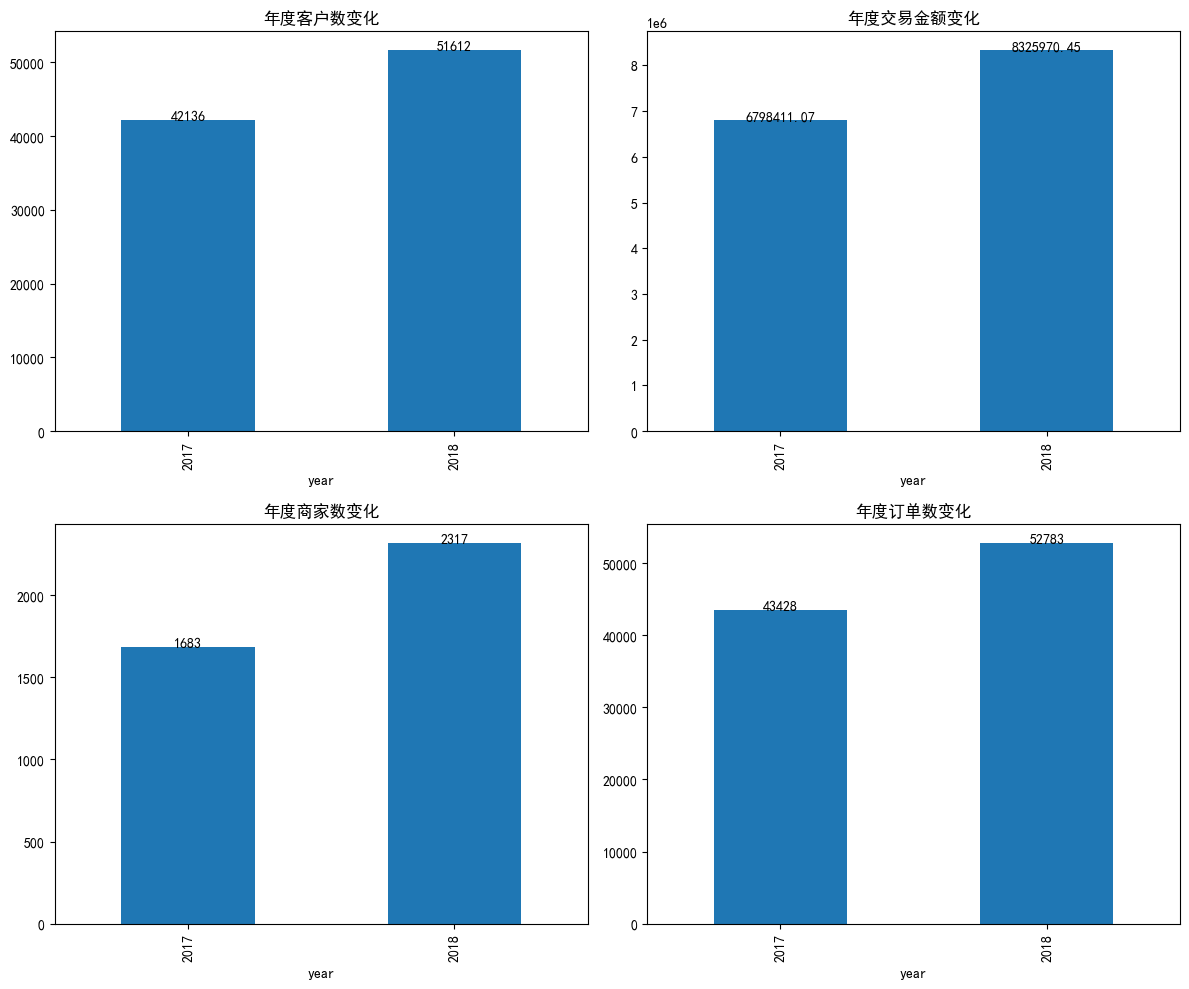

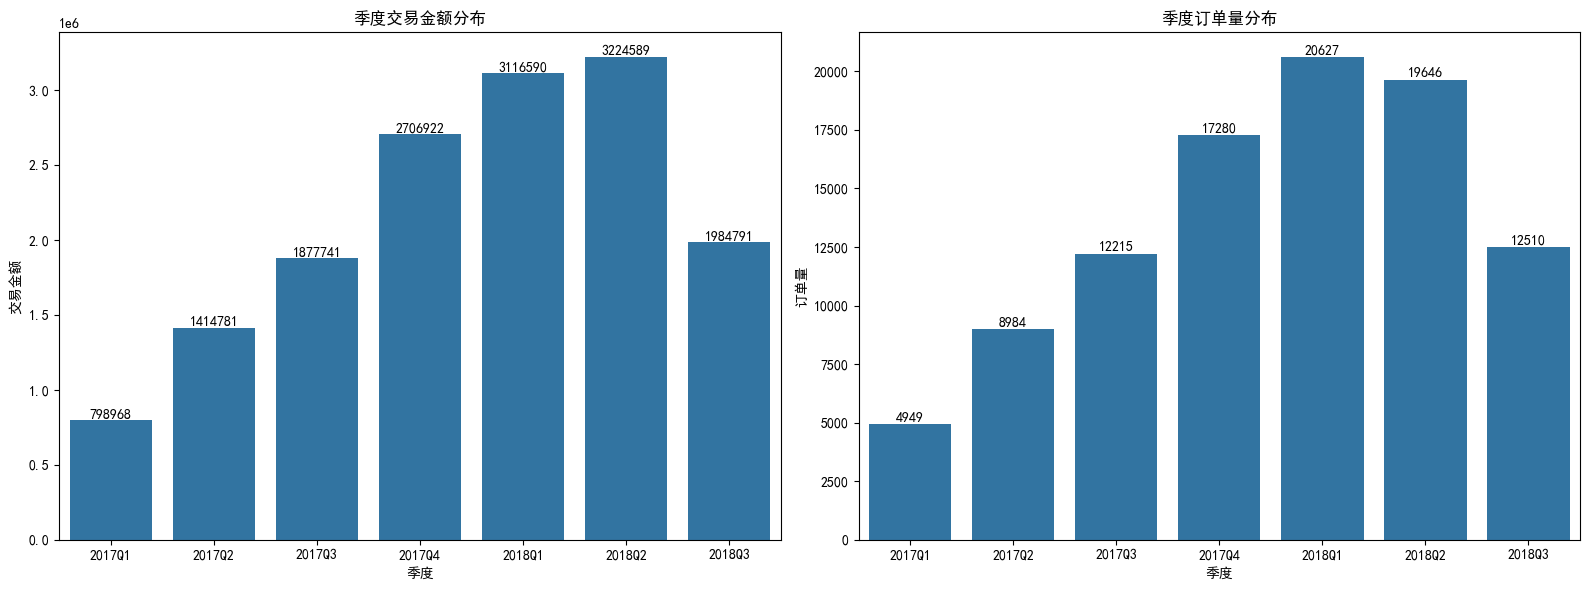

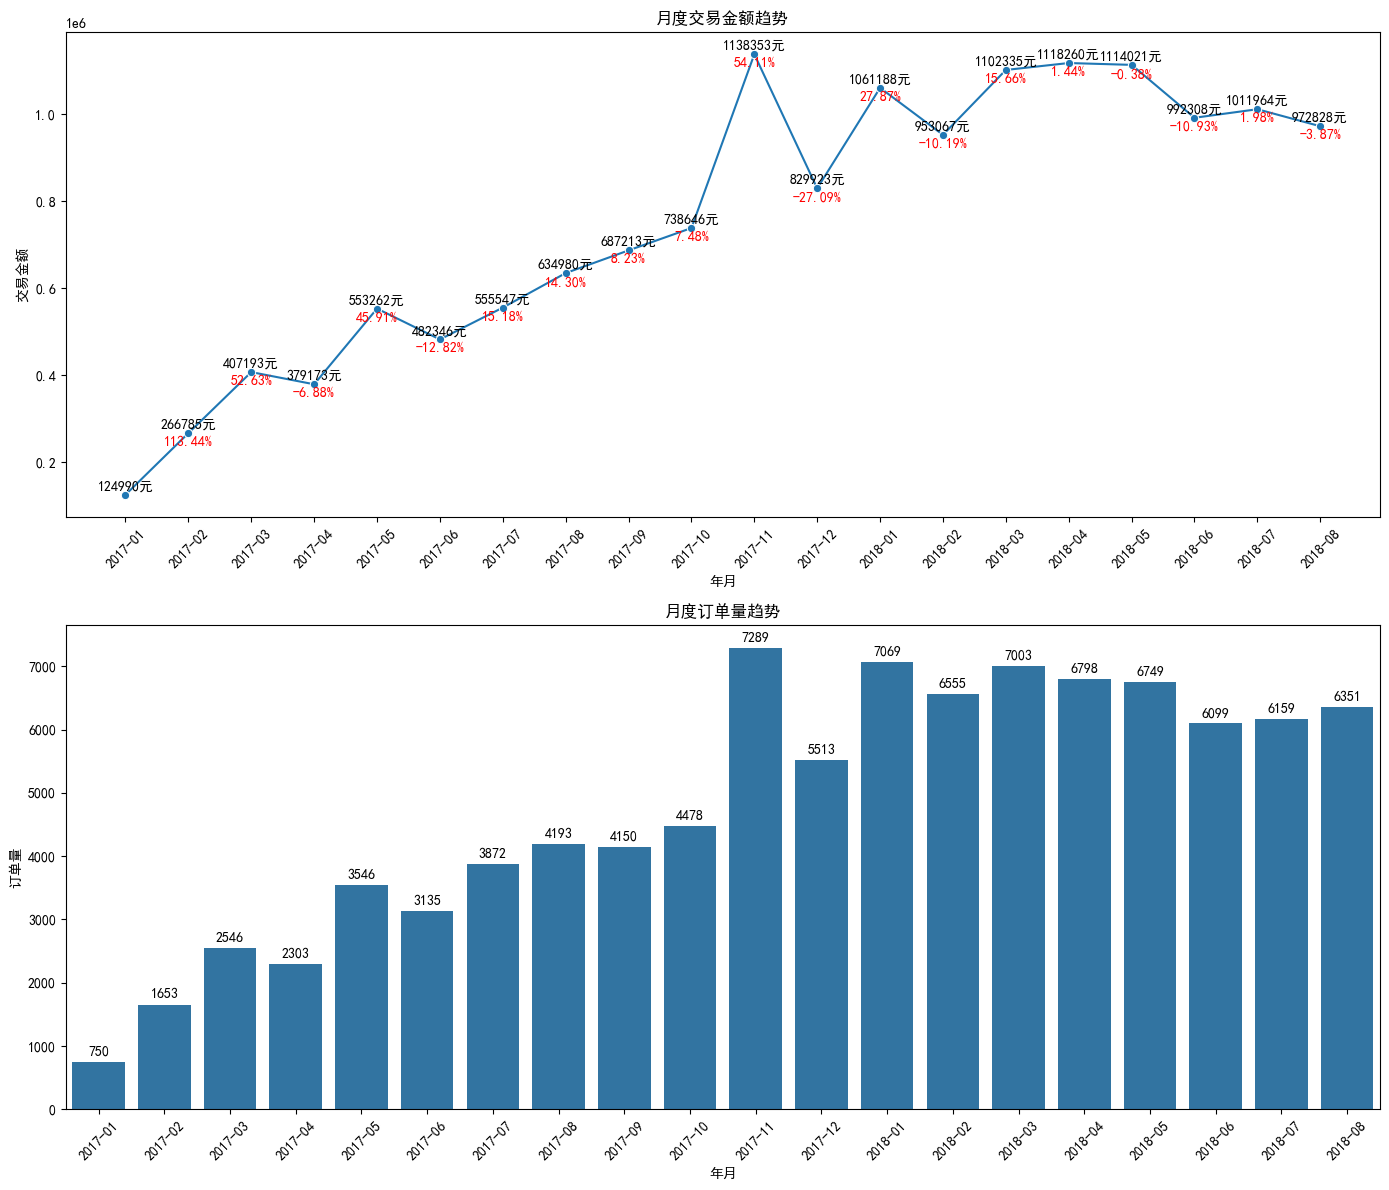

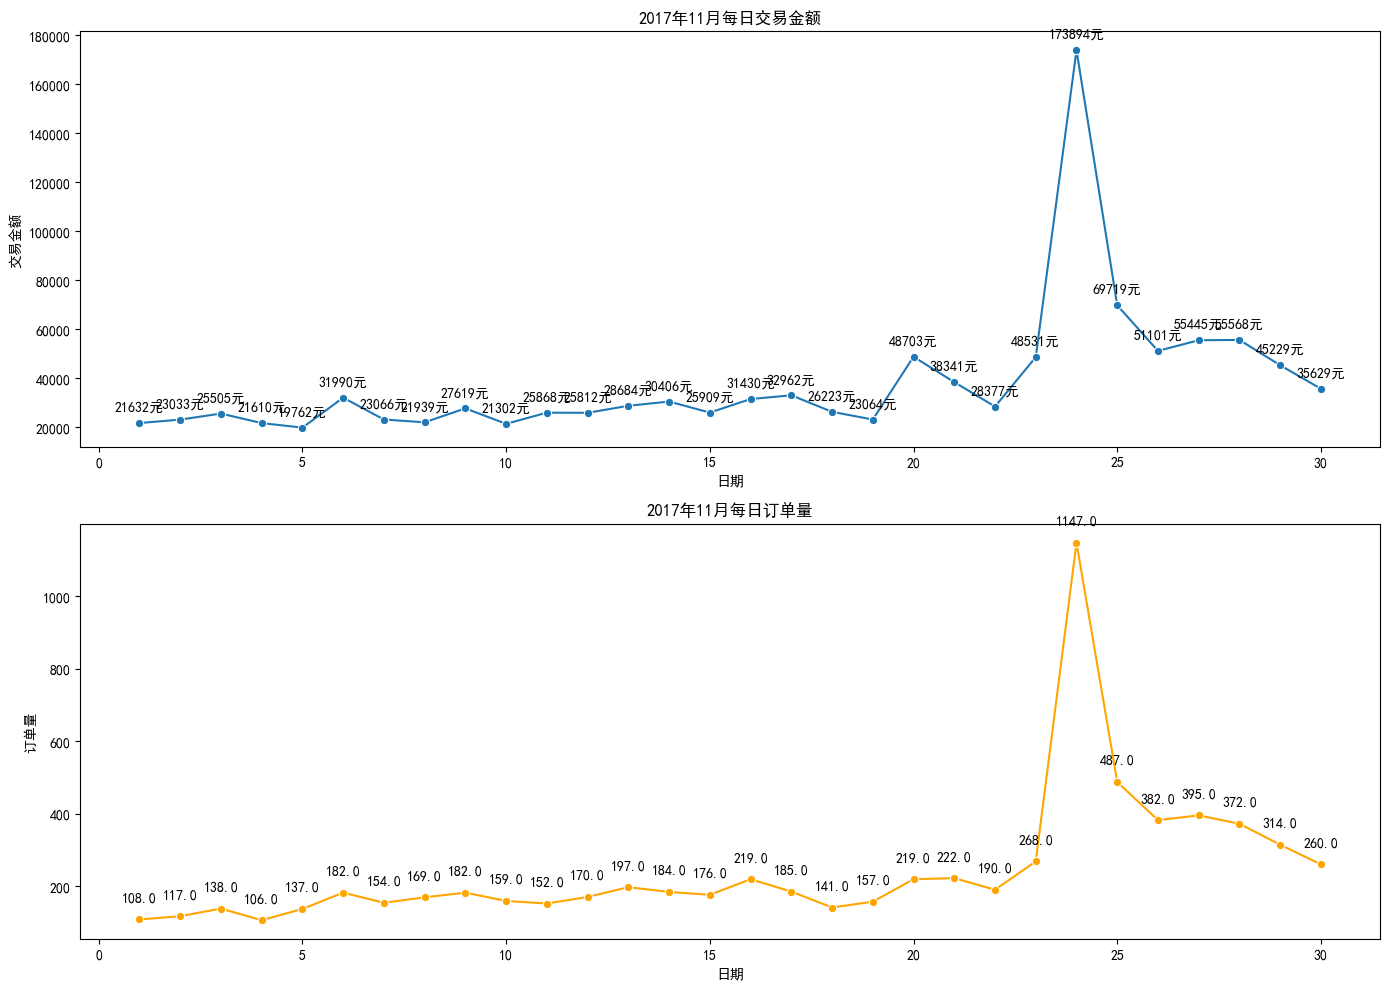

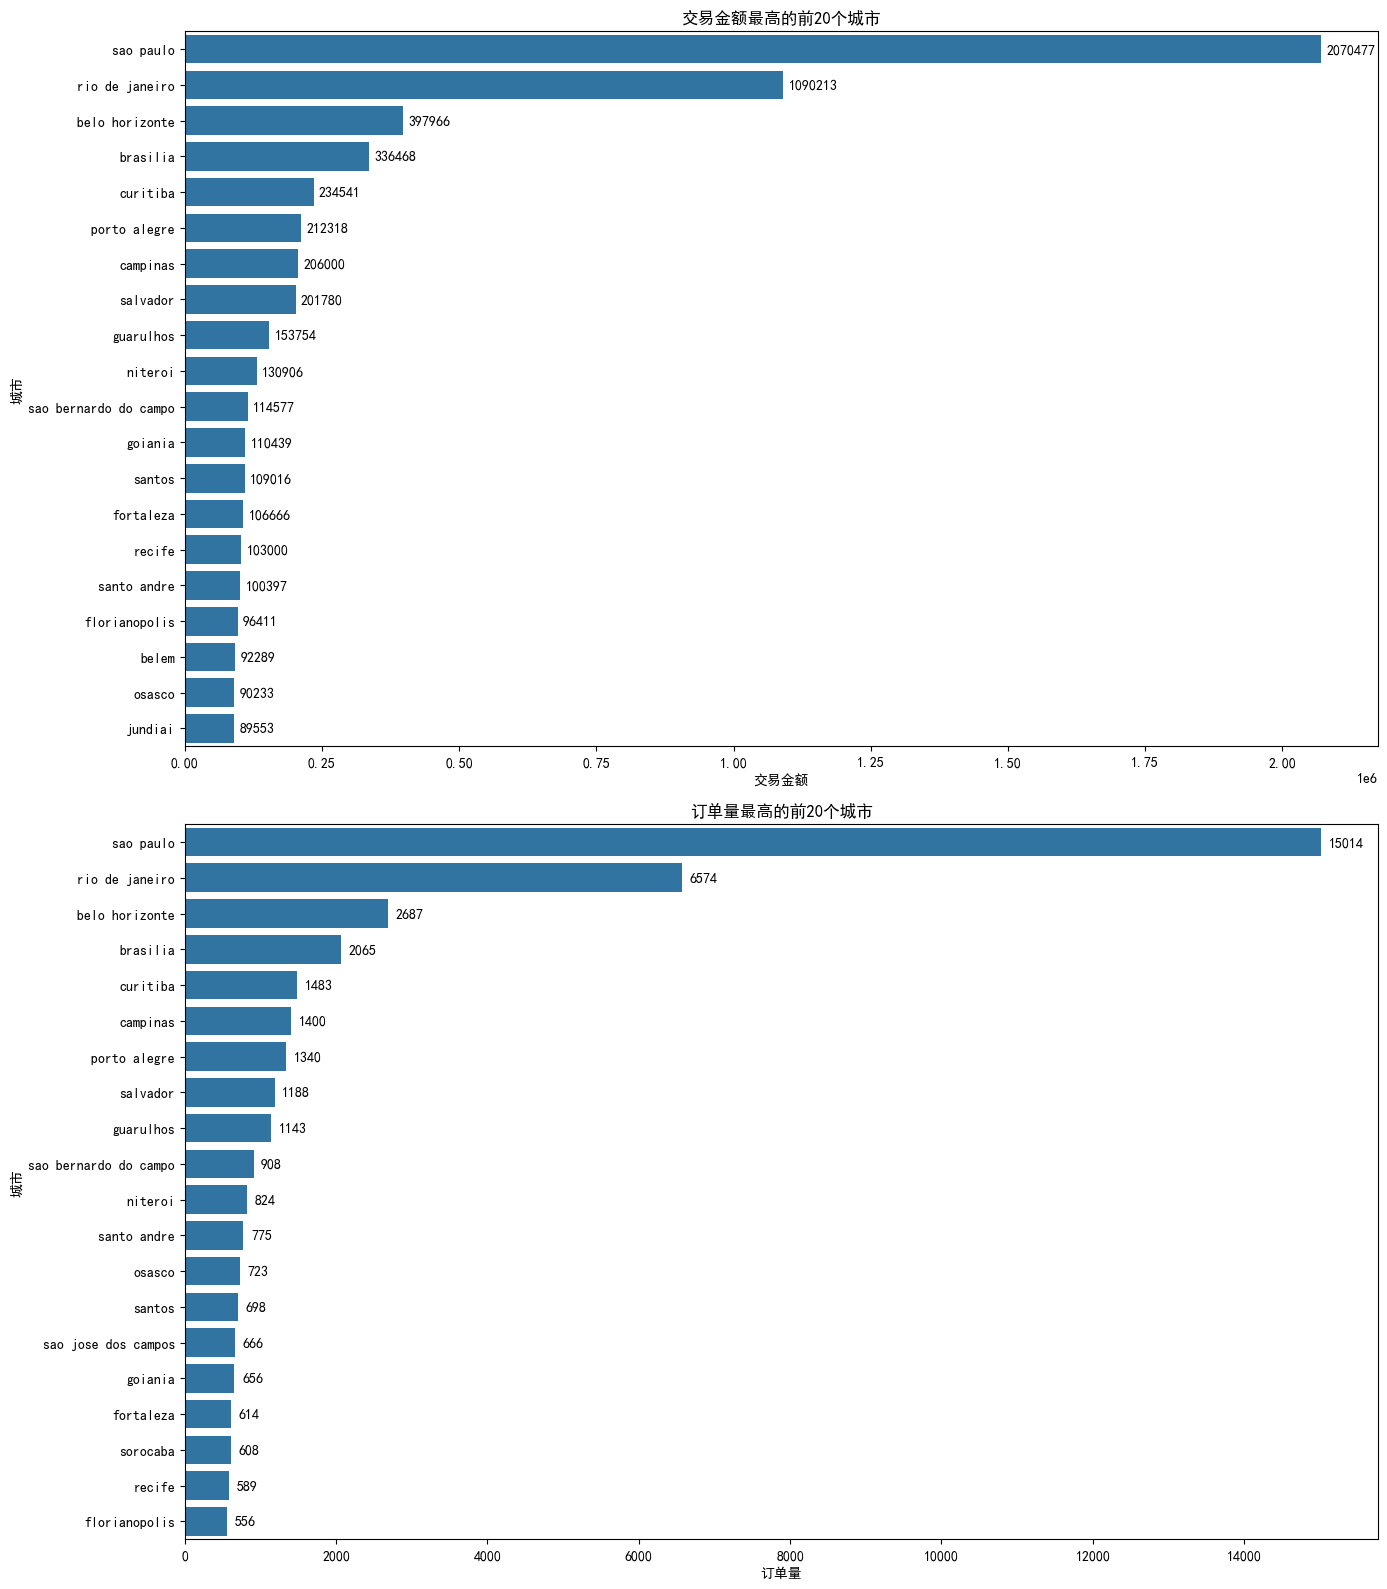

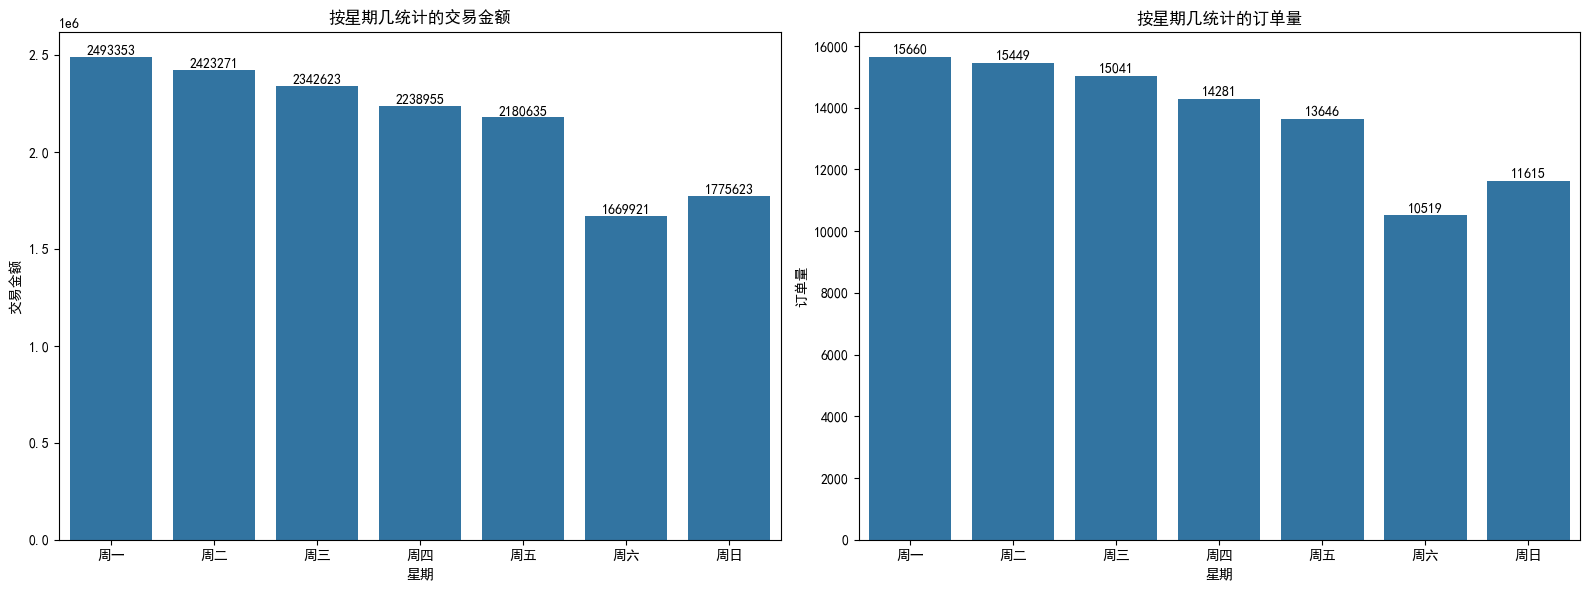

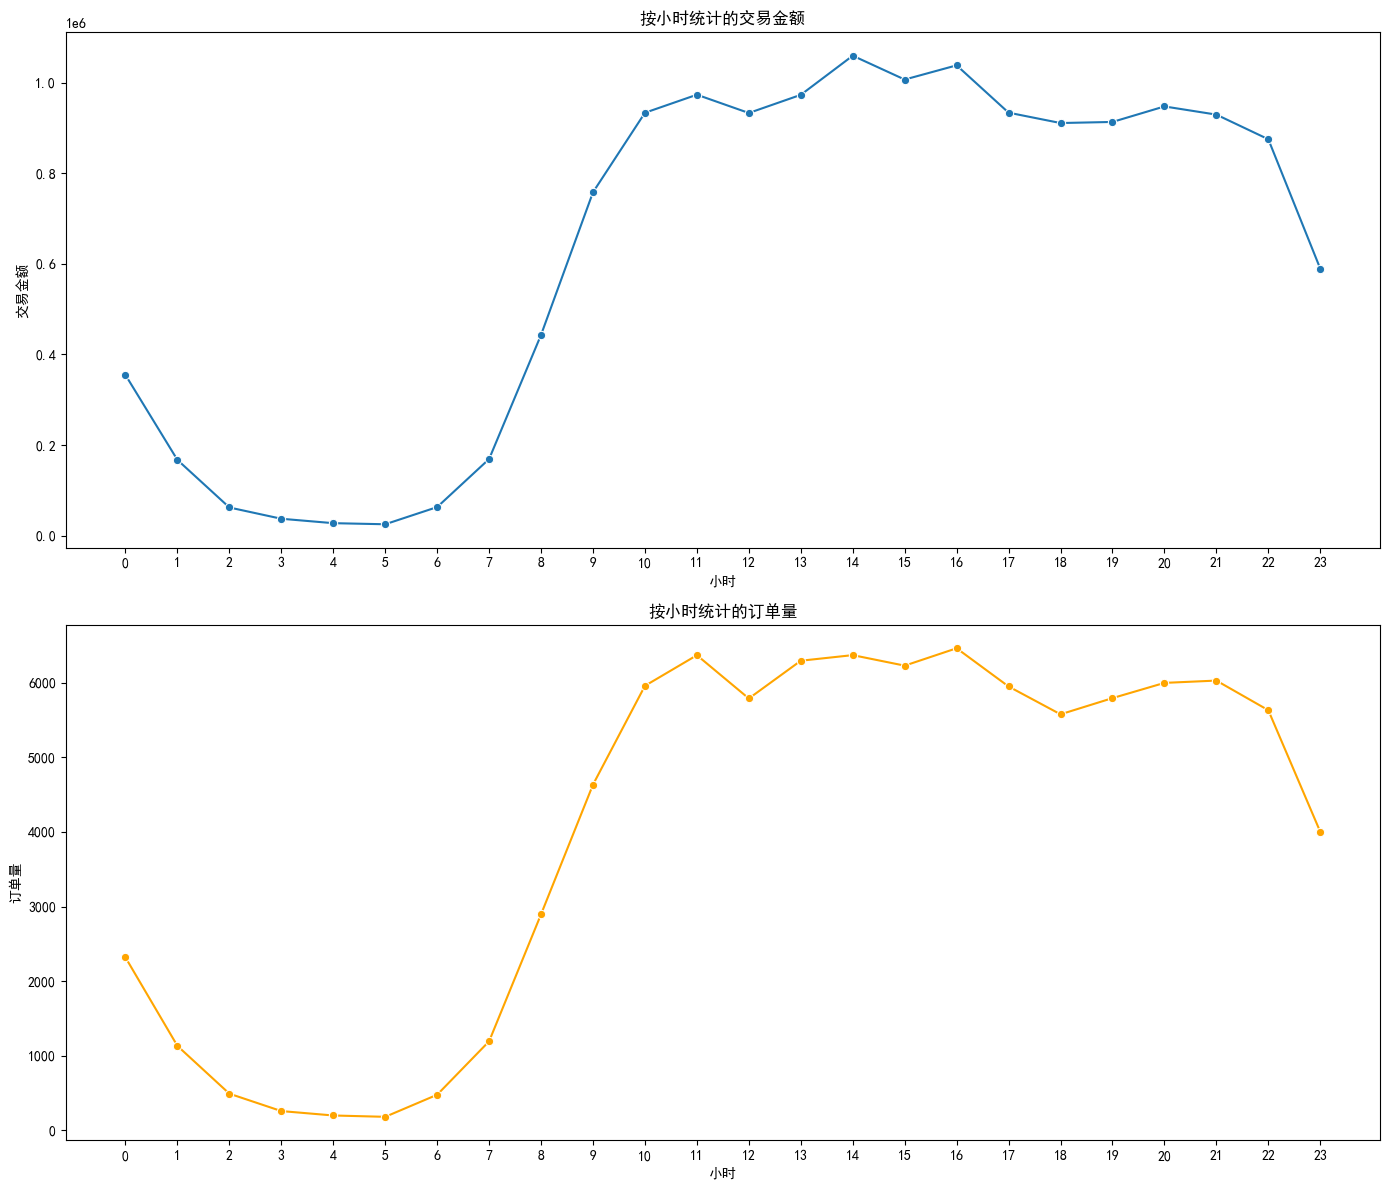

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def load_data(file_path: str) -> pd.DataFrame:
    """加载并预处理数据"""
    try:
        df = pd.read_csv(file_path, parse_dates=['下单时间'])
        print(f"数据加载成功，共{len(df)}条记录")
        return df
    except FileNotFoundError:
        print(f"错误：文件 '{file_path}' 不存在")
        return pd.DataFrame()
    except Exception as e:
        print(f"数据加载错误: {e}")
        return pd.DataFrame()

def calculate_basic_metrics(df: pd.DataFrame) -> Tuple[int, float, float, int, float]:
    """计算基础业务指标"""
    if df.empty:
        return 0, 0.0, 0.0, 0, 0.0
    
    # 计算客户相关指标
    user_count = df['客户唯一ID'].nunique()
    total_amount = df['支付金额'].sum()
    
    # 客单价计算逻辑：总金额/去重客户数
    customer_unit_price = total_amount / user_count if user_count > 0 else 0
    
    # 计算订单相关指标
    order_count = df['订单ID'].nunique()
    order_unit_price = total_amount / order_count if order_count > 0 else 0
    
    return user_count, total_amount, customer_unit_price, order_count, order_unit_price

def analyze_recent_trends(df: pd.DataFrame, years: int = 2) -> Optional[pd.DataFrame]:
    """分析近n年的业务趋势"""
    if df.empty:
        return None
    
    # 提取年份信息
    df['year'] = df['下单时间'].dt.year
    
    # 计算最近几年
    max_year = df['year'].max()
    recent_years = list(range(max_year - years + 1, max_year + 1))
    
    # 筛选最近几年的数据
    df_recent = df[df['year'].isin(recent_years)]
    
    # 按年分组统计
    trend = df_recent.groupby('year').agg({
        '客户唯一ID': pd.Series.nunique,
        '支付金额': 'sum',
        '卖家ID': pd.Series.nunique,
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '客户唯一ID': '客户数',
        '支付金额': '交易金额',
        '卖家ID': '商家数',
        '订单ID': '订单数'
    })
    
    # 计算增长率
    for col in ['客户数', '交易金额', '商家数', '订单数']:
        trend[f'{col}增长率'] = trend[col].pct_change()
    
    return trend

def analyze_quarterly_sales(df: pd.DataFrame) -> None:
    """分析季度交易情况"""
    if df.empty:
        print("没有数据可用于季度分析")
        return
    
    # 提取季度信息
    df['quarter'] = df['下单时间'].dt.to_period('Q')
    
    # 按季度分组统计
    quarterly_data = df.groupby('quarter').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 将Period类型转换为字符串以便绘图
    quarterly_data['quarter_str'] = quarterly_data['quarter'].astype(str)
    
    # 创建图表
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 季度交易金额柱状图
    sns.barplot(x='quarter_str', y='交易金额', data=quarterly_data, ax=axes[0])
    axes[0].set_title('季度交易金额分布')
    axes[0].set_xlabel('季度')
    axes[0].set_ylabel('交易金额')
    for i, v in enumerate(quarterly_data['交易金额']):
        axes[0].text(i, v + 10000, f'{v:.0f}', ha='center', rotation=0)
    
    # 季度订单量柱状图
    sns.barplot(x='quarter_str', y='订单量', data=quarterly_data, ax=axes[1])
    axes[1].set_title('季度订单量分布')
    axes[1].set_xlabel('季度')
    axes[1].set_ylabel('订单量')
    for i, v in enumerate(quarterly_data['订单量']):
        axes[1].text(i, v + 100, f'{v}', ha='center', rotation=0)
    
    plt.tight_layout()
    plt.savefig('quarterly_sales.png')
    print("季度分析图表已保存为 quarterly_sales.png")
    
    # 打印分析结果
    max_quarter_amount = quarterly_data.loc[quarterly_data['交易金额'].idxmax()]
    max_quarter_orders = quarterly_data.loc[quarterly_data['订单量'].idxmax()]
    
    print("\n季度交易分析结果:")
    print(f"交易金额最高的季度: {max_quarter_amount['quarter_str']}，金额为 {max_quarter_amount['交易金额']:.2f} 元")
    print(f"订单量最高的季度: {max_quarter_orders['quarter_str']}，订单量为 {max_quarter_orders['订单量']}")

def analyze_monthly_sales(df: pd.DataFrame) -> None:
    """分析月度交易情况"""
    if df.empty:
        print("没有数据可用于月度分析")
        return
    
    # 提取年月信息
    df['年月'] = df['下单时间'].dt.strftime('%Y-%m')
    
    # 按月分组统计
    monthly_data = df.groupby('年月').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 计算环比增长率
    monthly_data['交易金额环比增长率'] = monthly_data['交易金额'].pct_change() * 100
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # 月度交易金额折线图
    sns.lineplot(x='年月', y='交易金额', data=monthly_data, marker='o', ax=axes[0])
    axes[0].set_title('月度交易金额趋势')
    axes[0].set_xlabel('年月')
    axes[0].set_ylabel('交易金额')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 在折线图上标注交易金额和增长率
    for i, row in monthly_data.iterrows():
        axes[0].text(row['年月'], row['交易金额'] + 10000, f"{row['交易金额']:.0f}元", ha='center')
        if i > 0:  # 跳过第一个月，因为没有环比数据
            axes[0].text(row['年月'], row['交易金额'] - 30000, 
                        f"{row['交易金额环比增长率']:.2f}%", ha='center', color='red')
    
    # 月度订单量柱状图
    sns.barplot(x='年月', y='订单量', data=monthly_data, ax=axes[1])
    axes[1].set_title('月度订单量趋势')
    axes[1].set_xlabel('年月')
    axes[1].set_ylabel('订单量')
    axes[1].tick_params(axis='x', rotation=45)
    
    # 在柱状图上标注订单量
    for i, v in enumerate(monthly_data['订单量']):
        axes[1].text(i, v + 100, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('monthly_sales.png')
    print("月度分析图表已保存为 monthly_sales.png")
    
    # 打印分析结果
    max_month = monthly_data.loc[monthly_data['交易金额'].idxmax()]
    print("\n月度交易分析结果:")
    print(f"交易金额最高的月份: {max_month['年月']}，金额为 {max_month['交易金额']:.2f} 元，环比增长率为 {max_month['交易金额环比增长率']:.2f}%")
    print(f"该月订单量: {max_month['订单量']}")
    
    return monthly_data

def drill_down_november_2017(df: pd.DataFrame) -> None:
    """深入分析2017年11月的交易情况"""
    if df.empty:
        print("没有数据可用于深入分析")
        return
    
    # 筛选2017年11月的数据
    nov_2017 = df[(df['下单时间'].dt.year == 2017) & (df['下单时间'].dt.month == 11)]
    
    if nov_2017.empty:
        print("没有2017年11月的数据")
        return
    
    # 按日统计
    daily_data = nov_2017.groupby(nov_2017['下单时间'].dt.day).agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index().rename(columns={'下单时间': '日期'})
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # 每日交易金额折线图
    sns.lineplot(x='日期', y='交易金额', data=daily_data, marker='o', ax=axes[0])
    axes[0].set_title('2017年11月每日交易金额')
    axes[0].set_xlabel('日期')
    axes[0].set_ylabel('交易金额')
    
    # 在折线图上标注交易金额
    for i, row in daily_data.iterrows():
        axes[0].text(row['日期'], row['交易金额'] + 5000, f"{row['交易金额']:.0f}元", ha='center')
    
    # 每日订单量折线图
    sns.lineplot(x='日期', y='订单量', data=daily_data, marker='o', ax=axes[1], color='orange')
    axes[1].set_title('2017年11月每日订单量')
    axes[1].set_xlabel('日期')
    axes[1].set_ylabel('订单量')
    
    # 在折线图上标注订单量
    for i, row in daily_data.iterrows():
        axes[1].text(row['日期'], row['订单量'] + 50, f"{row['订单量']}", ha='center')
    
    plt.tight_layout()
    plt.savefig('november_2017_daily.png')
    print("2017年11月每日分析图表已保存为 november_2017_daily.png")
    
    # 找出峰值日期
    max_amount_day = daily_data.loc[daily_data['交易金额'].idxmax()]
    max_orders_day = daily_data.loc[daily_data['订单量'].idxmax()]
    
    print("\n2017年11月每日交易分析结果:")
    print(f"交易金额最高的日期: 11月{max_amount_day['日期']}日，金额为 {max_amount_day['交易金额']:.2f} 元")
    print(f"订单量最高的日期: 11月{max_orders_day['日期']}日，订单量为 {max_orders_day['订单量']}")
    
    # 检查是否是黑色星期五
    black_friday = 24  # 2017年11月24日是黑色星期五
    if max_amount_day['日期'] == black_friday or max_orders_day['日期'] == black_friday:
        print(f"注意: 11月{black_friday}日是黑色星期五，这可能是销量激增的原因之一")

def analyze_city_sales(df: pd.DataFrame, top_n: int = 20) -> None:
    """分析各城市交易情况"""
    if df.empty:
        print("没有数据可用于城市分析")
        return
    
    # 按城市分组统计
    city_data = df.groupby('客户城市').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 按交易金额排序并取前top_n个城市
    top_cities_by_amount = city_data.sort_values('交易金额', ascending=False).head(top_n)
    
    # 按订单量排序并取前top_n个城市
    top_cities_by_orders = city_data.sort_values('订单量', ascending=False).head(top_n)
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 16))
    
    # 交易金额最高的城市柱状图
    sns.barplot(x='交易金额', y='客户城市', data=top_cities_by_amount, ax=axes[0])
    axes[0].set_title(f'交易金额最高的前{top_n}个城市')
    axes[0].set_xlabel('交易金额')
    axes[0].set_ylabel('城市')
    for i, v in enumerate(top_cities_by_amount['交易金额']):
        axes[0].text(v + 10000, i, f'{v:.0f}', va='center')
    
    # 订单量最高的城市柱状图
    sns.barplot(x='订单量', y='客户城市', data=top_cities_by_orders, ax=axes[1])
    axes[1].set_title(f'订单量最高的前{top_n}个城市')
    axes[1].set_xlabel('订单量')
    axes[1].set_ylabel('城市')
    for i, v in enumerate(top_cities_by_orders['订单量']):
        axes[1].text(v + 100, i, f'{v}', va='center')
    
    plt.tight_layout()
    plt.savefig('city_sales.png')
    print(f"城市交易分析图表已保存为 city_sales.png")
    
    # 打印分析结果
    top_city_by_amount = top_cities_by_amount.iloc[0]
    top_city_by_orders = top_cities_by_orders.iloc[0]
    
    print("\n城市交易分析结果:")
    print(f"交易金额最高的城市: {top_city_by_amount['客户城市']}，金额为 {top_city_by_amount['交易金额']:.2f} 元")
    print(f"订单量最高的城市: {top_city_by_orders['客户城市']}，订单量为 {top_city_by_orders['订单量']}")
    
    # 计算占比
    total_amount = city_data['交易金额'].sum()
    total_orders = city_data['订单量'].sum()
    
    print(f"{top_city_by_amount['客户城市']}的交易金额占总体的比例: {top_city_by_amount['交易金额']/total_amount*100:.2f}%")
    print(f"{top_city_by_orders['客户城市']}的订单量占总体的比例: {top_city_by_orders['订单量']/total_orders*100:.2f}%")

def analyze_weekday_sales(df: pd.DataFrame) -> None:
    """分析工作日交易情况"""
    if df.empty:
        print("没有数据可用于工作日分析")
        return
    
    # 提取星期几信息 (0=周一, 6=周日)
    df['weekday'] = df['下单时间'].dt.weekday
    
    # 按星期几分组统计
    weekday_data = df.groupby('weekday').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 将星期几数字转换为中文
    weekday_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
    weekday_data['weekday_name'] = weekday_data['weekday'].apply(lambda x: weekday_names[x])
    
    # 创建图表
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 按星期几统计的交易金额柱状图
    sns.barplot(x='weekday_name', y='交易金额', data=weekday_data, ax=axes[0])
    axes[0].set_title('按星期几统计的交易金额')
    axes[0].set_xlabel('星期')
    axes[0].set_ylabel('交易金额')
    for i, v in enumerate(weekday_data['交易金额']):
        axes[0].text(i, v + 10000, f'{v:.0f}', ha='center')
    
    # 按星期几统计的订单量柱状图
    sns.barplot(x='weekday_name', y='订单量', data=weekday_data, ax=axes[1])
    axes[1].set_title('按星期几统计的订单量')
    axes[1].set_xlabel('星期')
    axes[1].set_ylabel('订单量')
    for i, v in enumerate(weekday_data['订单量']):
        axes[1].text(i, v + 100, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('weekday_sales.png')
    print("工作日交易分析图表已保存为 weekday_sales.png")
    
    # 打印分析结果
    max_amount_weekday = weekday_data.loc[weekday_data['交易金额'].idxmax()]
    max_orders_weekday = weekday_data.loc[weekday_data['订单量'].idxmax()]
    
    print("\n工作日交易分析结果:")
    print(f"交易金额最高的是: {max_amount_weekday['weekday_name']}，金额为 {max_amount_weekday['交易金额']:.2f} 元")
    print(f"订单量最高的是: {max_orders_weekday['weekday_name']}，订单量为 {max_orders_weekday['订单量']}")
    
    # 区分工作日和周末
    weekday_data['is_weekday'] = weekday_data['weekday'] < 5
    weekday_stats = weekday_data.groupby('is_weekday').agg({
        '交易金额': 'sum',
        '订单量': 'sum'
    }).rename(index={True: '工作日', False: '周末'})
    
    print("\n工作日与周末对比:")
    print(weekday_stats)

def analyze_time_period_sales(df: pd.DataFrame) -> None:
    """分析时间段交易情况"""
    if df.empty:
        print("没有数据可用于时间段分析")
        return
    
    # 提取小时信息
    df['hour'] = df['下单时间'].dt.hour
    
    # 按小时分组统计
    hour_data = df.groupby('hour').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 创建时间段标签
    def get_time_period(hour):
        if 7 <= hour < 12:
            return '上午 (7-12点)'
        elif 12 <= hour < 18:
            return '下午 (12-18点)'
        elif 18 <= hour < 23:
            return '晚上 (18-23点)'
        else:
            return '深夜 (23-7点)'
    
    hour_data['time_period'] = hour_data['hour'].apply(get_time_period)
    
    # 按时间段分组统计
    period_data = hour_data.groupby('time_period').agg({
        '交易金额': 'sum',
        '订单量': 'sum'
    }).reset_index()
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # 按小时统计的交易金额折线图
    sns.lineplot(x='hour', y='交易金额', data=hour_data, marker='o', ax=axes[0])
    axes[0].set_title('按小时统计的交易金额')
    axes[0].set_xlabel('小时')
    axes[0].set_ylabel('交易金额')
    axes[0].set_xticks(range(0, 24))
    
    # 按小时统计的订单量折线图
    sns.lineplot(x='hour', y='订单量', data=hour_data, marker='o', ax=axes[1], color='orange')
    axes[1].set_title('按小时统计的订单量')
    axes[1].set_xlabel('小时')
    axes[1].set_ylabel('订单量')
    axes[1].set_xticks(range(0, 24))
    
    plt.tight_layout()
    plt.savefig('time_period_sales.png')
    print("时间段交易分析图表已保存为 time_period_sales.png")
    
    # 打印分析结果
    max_amount_hour = hour_data.loc[hour_data['交易金额'].idxmax()]
    max_orders_hour = hour_data.loc[hour_data['订单量'].idxmax()]
    
    print("\n时间段交易分析结果:")
    print(f"交易金额最高的小时: {max_amount_hour['hour']}点，金额为 {max_amount_hour['交易金额']:.2f} 元")
    print(f"订单量最高的小时: {max_orders_hour['hour']}点，订单量为 {max_orders_hour['订单量']}")
    
    print("\n按时间段统计的交易情况:")
    print(period_data)

def visualize_trends(trend: pd.DataFrame) -> None:
    """可视化趋势分析结果"""
    if trend is None or trend.empty:
        print("没有趋势数据可可视化")
        return
    
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 客户数趋势
    trend['客户数'].plot(kind='bar', ax=axes[0, 0], title='年度客户数变化')
    for i, v in enumerate(trend['客户数']):
        axes[0, 0].text(i, v + 10, f'{v}', ha='center')
    
    # 交易金额趋势
    trend['交易金额'].plot(kind='bar', ax=axes[0, 1], title='年度交易金额变化')
    for i, v in enumerate(trend['交易金额']):
        axes[0, 1].text(i, v + 1000, f'{v:.2f}', ha='center')
    
    # 商家数趋势
    trend['商家数'].plot(kind='bar', ax=axes[1, 0], title='年度商家数变化')
    for i, v in enumerate(trend['商家数']):
        axes[1, 0].text(i, v + 1, f'{v}', ha='center')
    
    # 订单数趋势
    trend['订单数'].plot(kind='bar', ax=axes[1, 1], title='年度订单数变化')
    for i, v in enumerate(trend['订单数']):
        axes[1, 1].text(i, v + 10, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('business_trends.png')
    print("趋势图表已保存为 business_trends.png")

def main():
    """主函数，执行完整分析流程"""
    file_path = '../Orders_merged_zh_cleaned_2017-2018.csv'
    
    # 加载数据
    df = load_data(file_path)
    if df.empty:
        return
    
    # 计算基础指标
    user_count, total_amount, customer_unit_price, order_count, order_unit_price = calculate_basic_metrics(df)
    print("\n基础业务指标:")
    print(f"去重客户数: {user_count}")
    print(f"总交易金额: {total_amount:.2f}")
    print(f"客单价(总金额/去重客户数): {customer_unit_price:.2f}")
    print(f"订单量: {order_count}")
    print(f"笔单价(总金额/订单数): {order_unit_price:.2f}")
    
    # 分析趋势
    trend = analyze_recent_trends(df, years=2)
    if trend is not None:
        print("\n近2年业务趋势:")
        print(trend.to_string(float_format='{:.2f}'.format))
        
        # 可视化趋势
        visualize_trends(trend)
    
    # 季度交易分析
    analyze_quarterly_sales(df)
    
    # 月度交易分析
    analyze_monthly_sales(df)
    
    # 深入分析2017年11月
    drill_down_november_2017(df)
    
    # 城市交易分析
    analyze_city_sales(df, top_n=20)
    
    # 工作日交易分析
    analyze_weekday_sales(df)
    
    # 时间段交易分析
    analyze_time_period_sales(df)

if __name__ == "__main__":
    main()    

数据加载成功，共96211条记录

基础业务指标:
去重客户数: 93104
总交易金额: 15124381.52
客单价(总金额/去重客户数): 162.45
订单量: 96211
笔单价(总金额/订单数): 157.20

近2年业务趋势:
        客户数       交易金额   商家数    订单数  客户数增长率  交易金额增长率  商家数增长率  订单数增长率
year                                                                
2017  42136 6798411.07  1683  43428     NaN      NaN     NaN     NaN
2018  51612 8325970.45  2317  52783    0.22     0.22    0.38    0.22
趋势图表已保存为 business_trends.png
季度分析图表已保存为 quarterly_sales.png

季度交易分析结果:
交易金额最高的季度: 2018Q2，金额为 3224589.24 元
订单量最高的季度: 2018Q1，订单量为 20627
月度分析图表已保存为 monthly_sales.png

月度交易分析结果:
交易金额最高的月份: 2017-11，金额为 1138352.92 元，环比增长率为 54.11%
该月订单量: 7289
2017年11月每日分析图表已保存为 november_2017_daily.png

2017年11月每日交易分析结果:
交易金额最高的日期: 11月24.0日，金额为 173894.10 元
订单量最高的日期: 11月24.0日，订单量为 1147.0
注意: 11月24日是黑色星期五，这可能是销量激增的原因之一
城市交易分析图表已保存为 city_sales.png

城市交易分析结果:
交易金额最高的城市: sao paulo，金额为 2070476.96 元
订单量最高的城市: sao paulo，订单量为 15014
sao paulo的交易金额占总体的比例: 13.69%
sao paulo的订单量占总体的比例: 15.61%
工作日交易分析图表已保存为 weekday_sales.png

工作日交易分析

C:\Users\86180\AppData\Local\Temp\ipykernel_39240\3663557448.py:847: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amount_range = df.groupby('金额区间').agg({


交易金额分布图表已保存为 amount_distribution.png


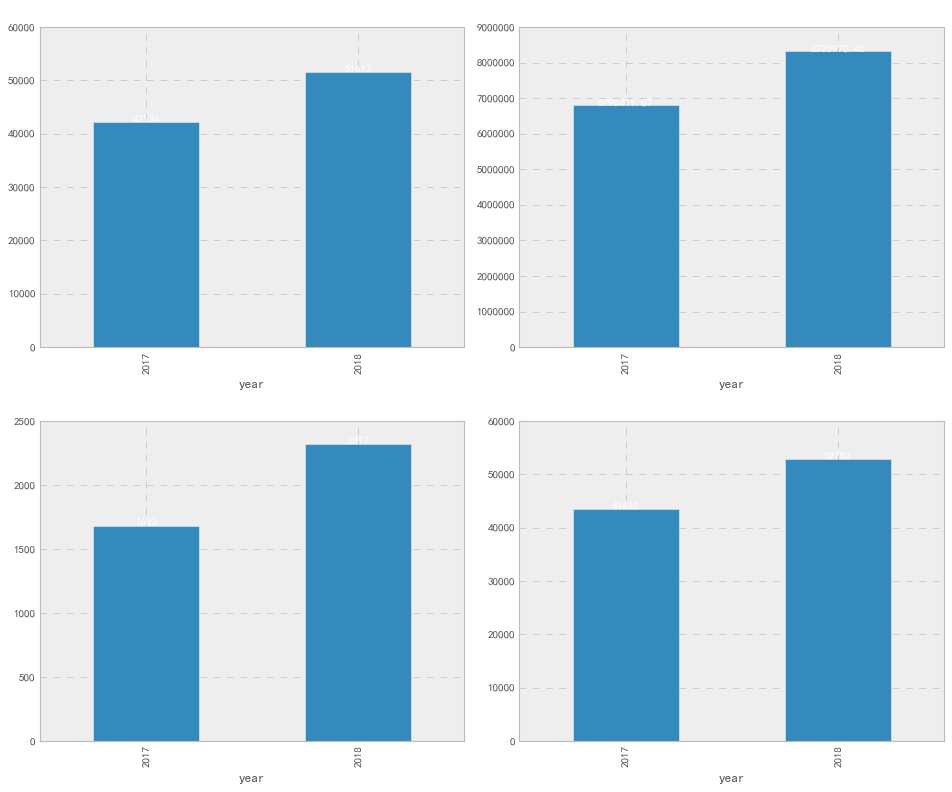

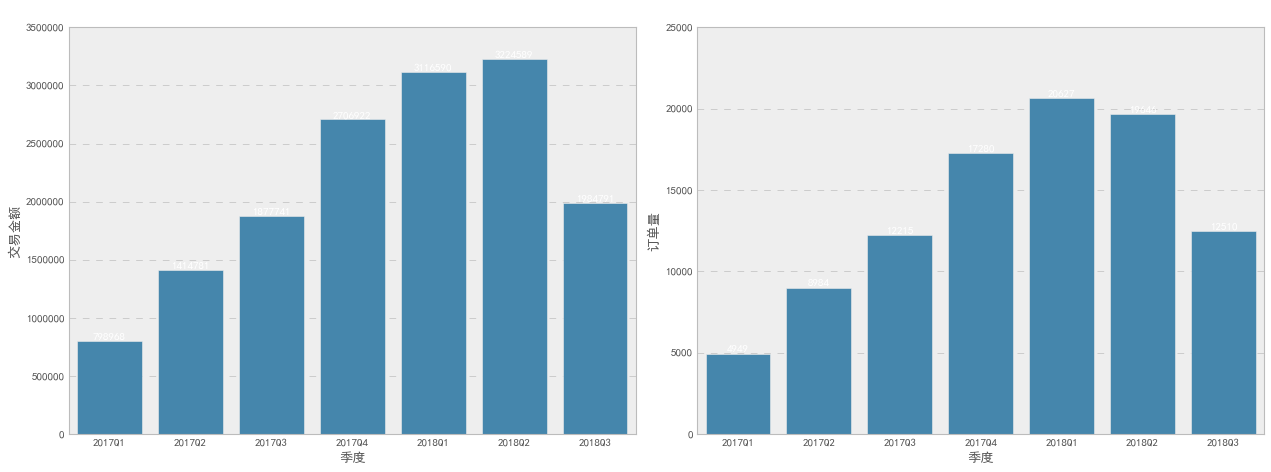

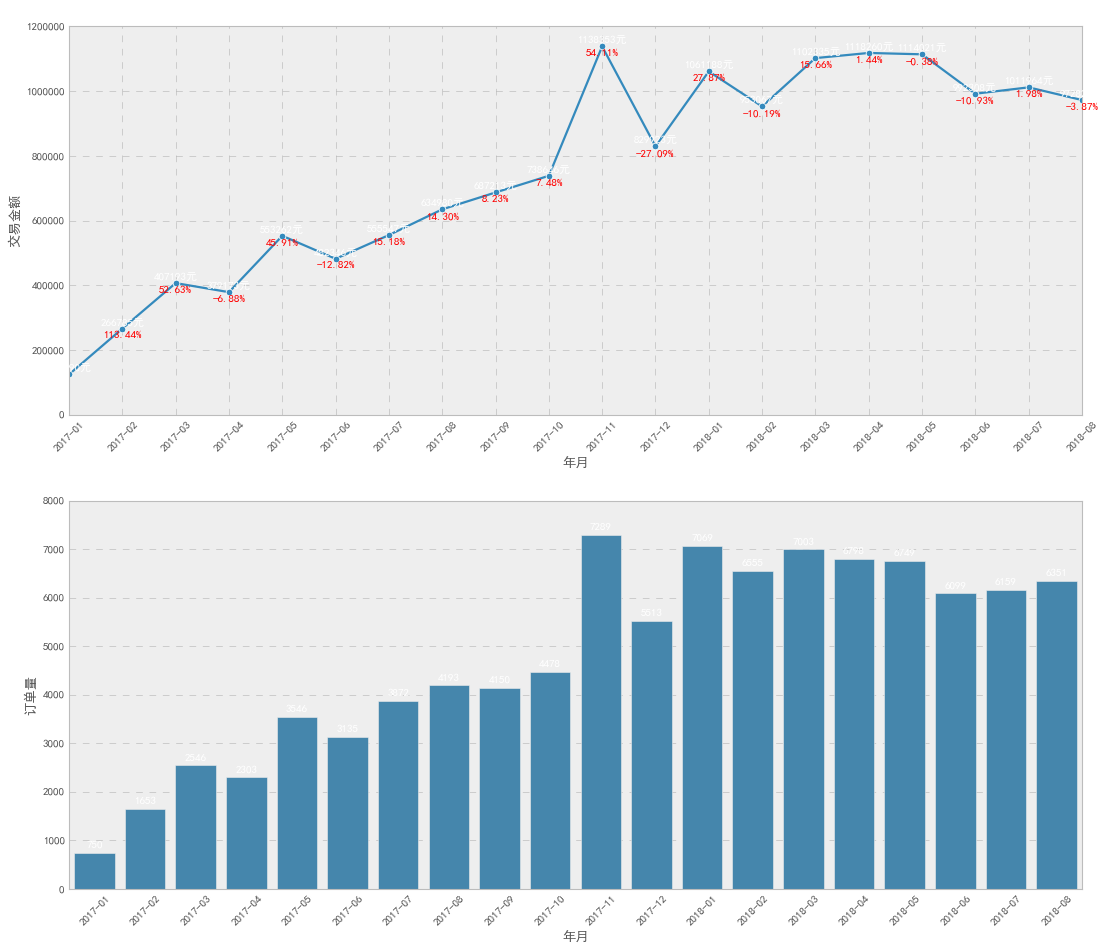

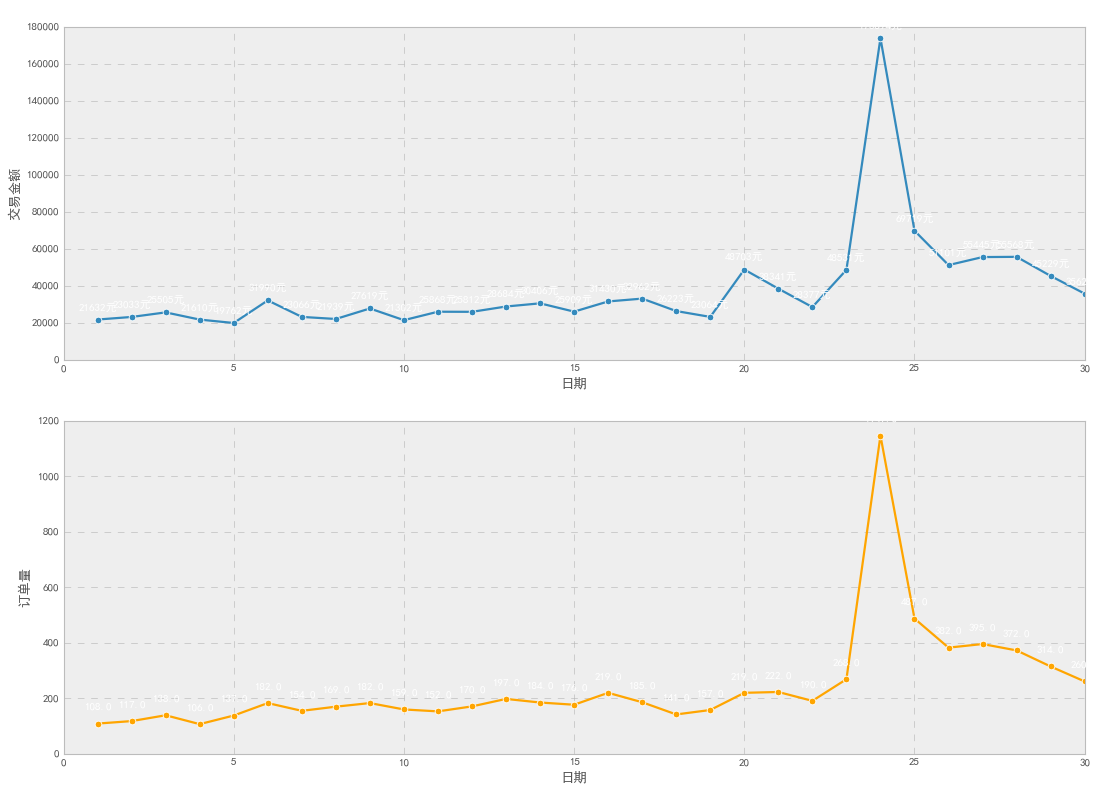

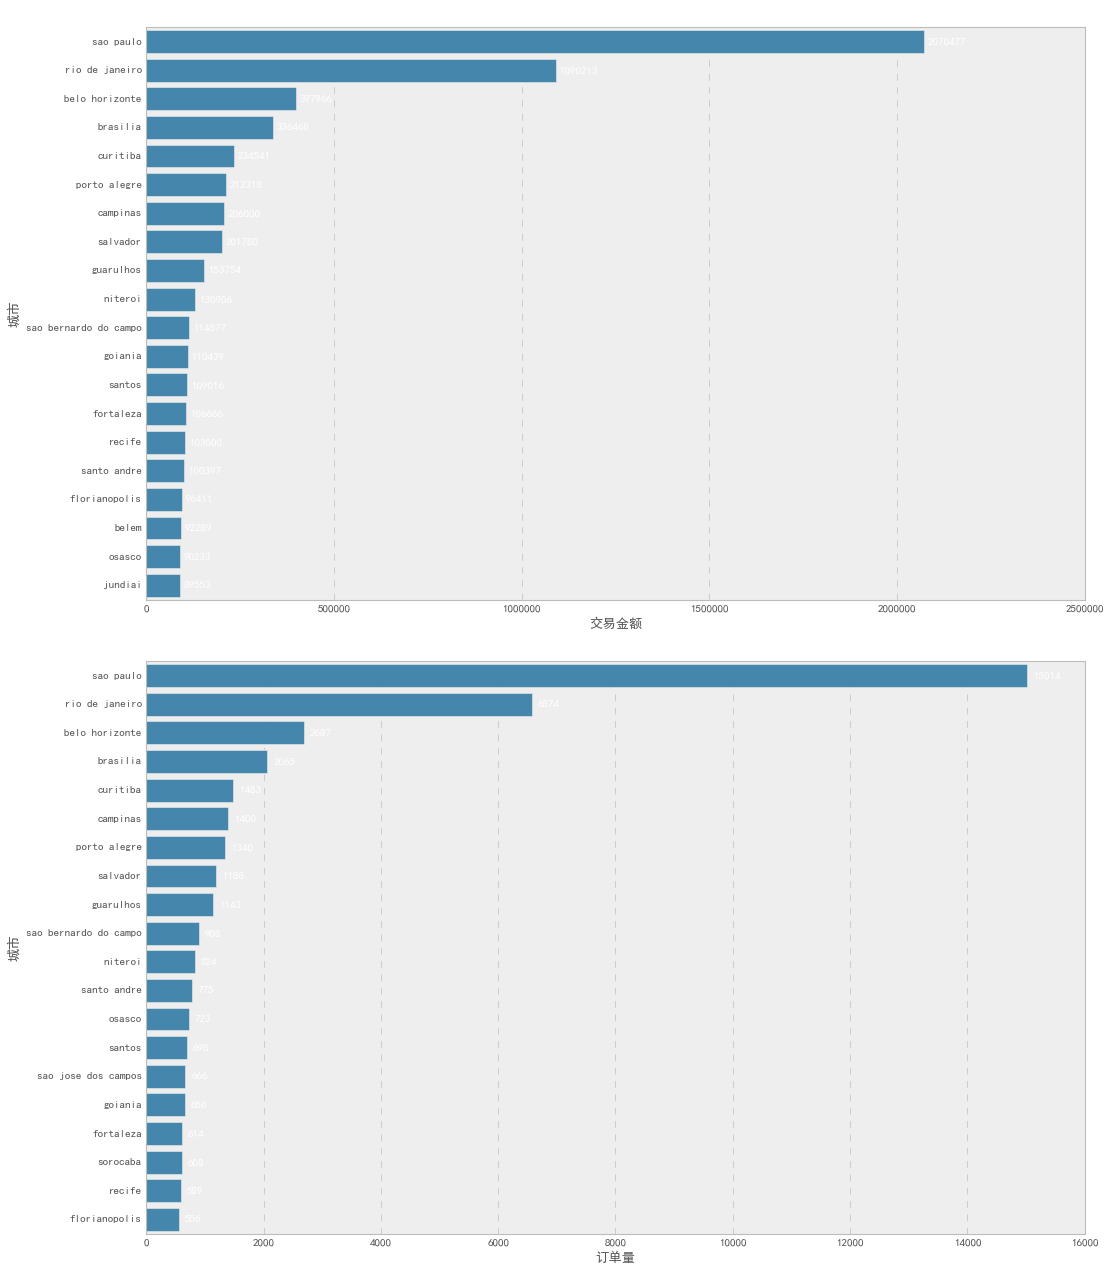

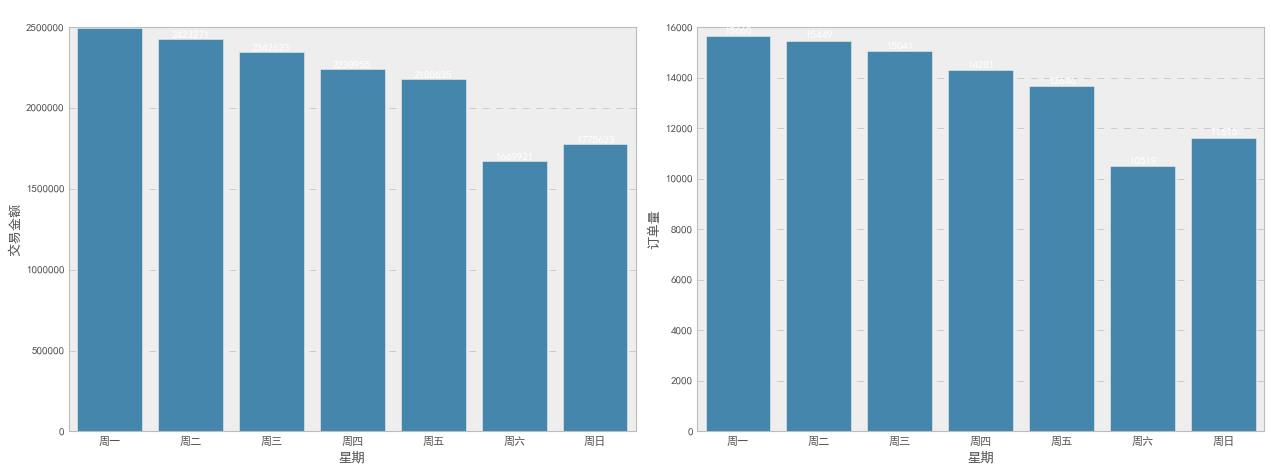

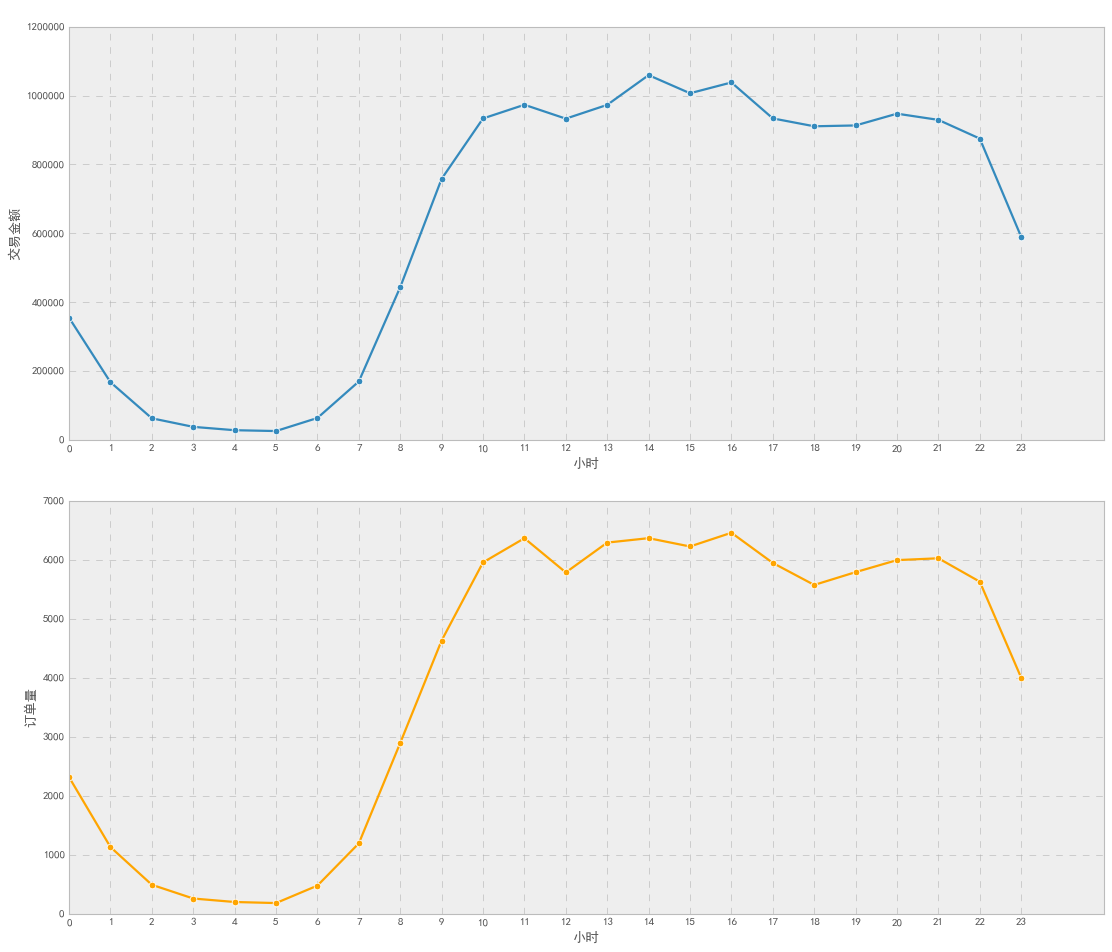

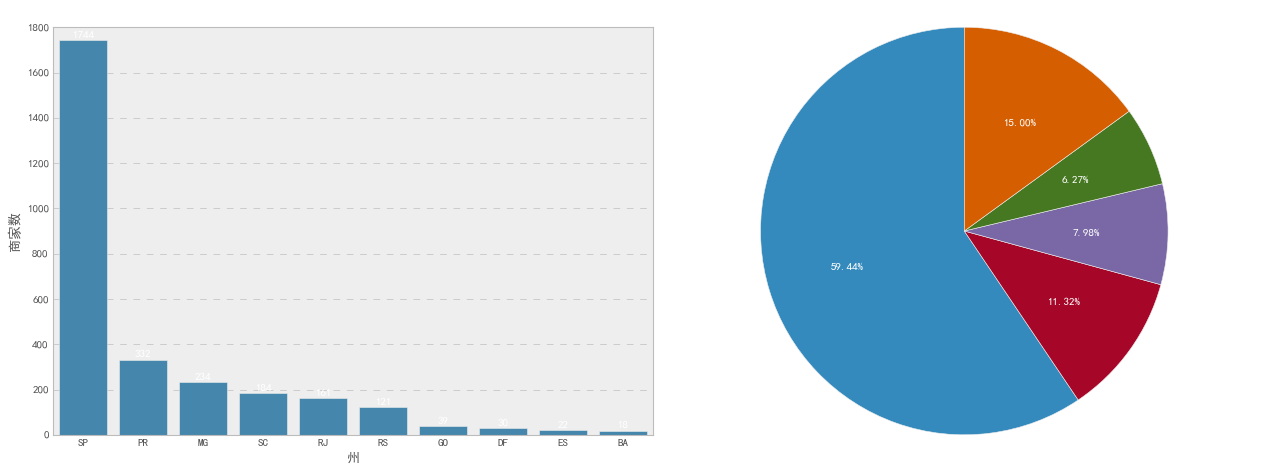

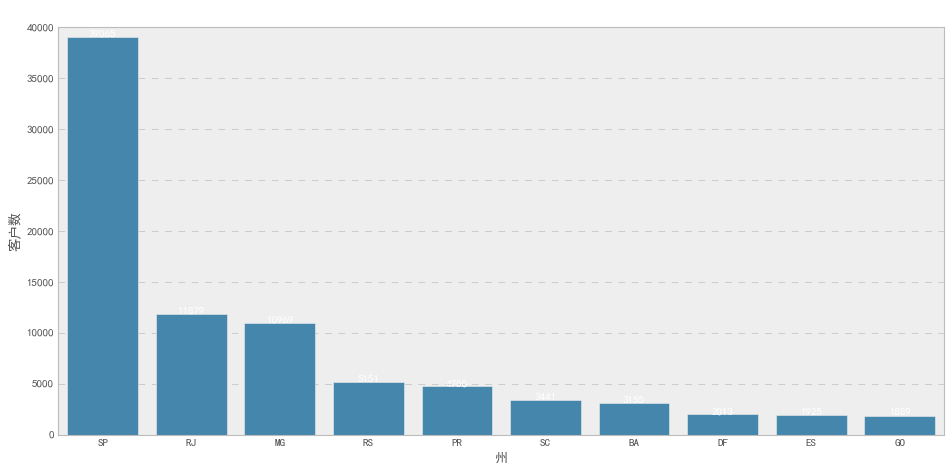

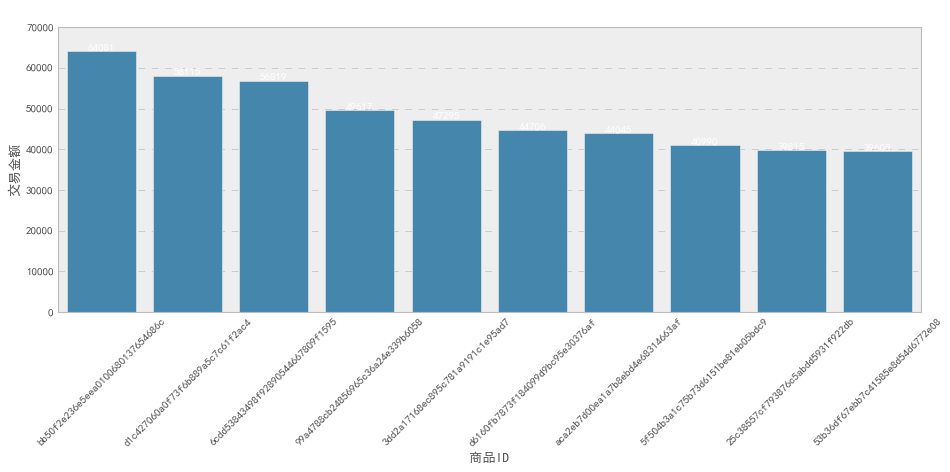

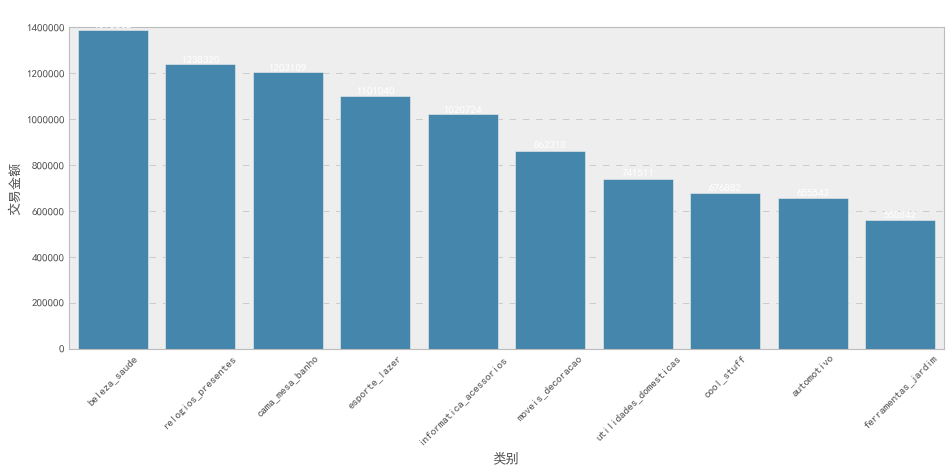

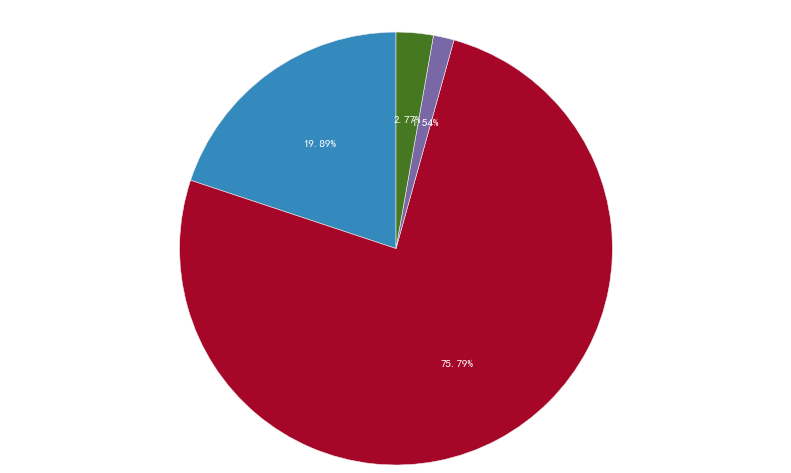

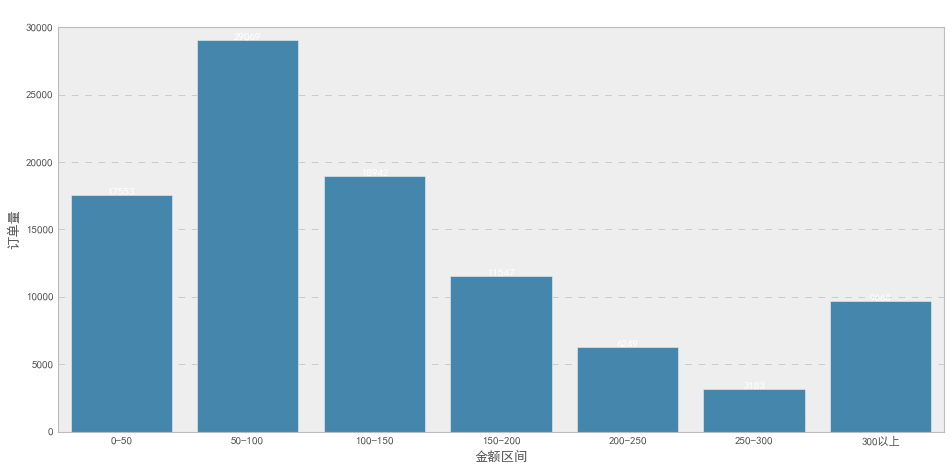

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Optional
import seaborn as sns
import numpy as np
plt.style.use('bmh')
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def load_data(file_path: str) -> pd.DataFrame:
    """加载并预处理数据"""
    try:
        df = pd.read_csv(file_path, parse_dates=['下单时间'])
        print(f"数据加载成功，共{len(df)}条记录")
        return df
    except FileNotFoundError:
        print(f"错误：文件 '{file_path}' 不存在")
        return pd.DataFrame()
    except Exception as e:
        print(f"数据加载错误: {e}")
        return pd.DataFrame()

def calculate_basic_metrics(df: pd.DataFrame) -> Tuple[int, float, float, int, float]:
    """计算基础业务指标"""
    if df.empty:
        return 0, 0.0, 0.0, 0, 0.0
    
    # 计算客户相关指标
    user_count = df['客户唯一ID'].nunique()
    total_amount = df['支付金额'].sum()
    
    # 客单价计算逻辑：总金额/去重客户数
    customer_unit_price = total_amount / user_count if user_count > 0 else 0
    
    # 计算订单相关指标
    order_count = df['订单ID'].nunique()
    order_unit_price = total_amount / order_count if order_count > 0 else 0
    
    return user_count, total_amount, customer_unit_price, order_count, order_unit_price

def analyze_recent_trends(df: pd.DataFrame, years: int = 2) -> Optional[pd.DataFrame]:
    """分析近n年的业务趋势"""
    if df.empty:
        return None
    
    # 提取年份信息
    df['year'] = df['下单时间'].dt.year
    
    # 计算最近几年
    max_year = df['year'].max()
    recent_years = list(range(max_year - years + 1, max_year + 1))
    
    # 筛选最近几年的数据
    df_recent = df[df['year'].isin(recent_years)]
    
    # 按年分组统计
    trend = df_recent.groupby('year').agg({
        '客户唯一ID': pd.Series.nunique,
        '支付金额': 'sum',
        '卖家ID': pd.Series.nunique,
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '客户唯一ID': '客户数',
        '支付金额': '交易金额',
        '卖家ID': '商家数',
        '订单ID': '订单数'
    })
    
    # 计算增长率
    for col in ['客户数', '交易金额', '商家数', '订单数']:
        trend[f'{col}增长率'] = trend[col].pct_change()
    
    return trend

def analyze_quarterly_sales(df: pd.DataFrame) -> None:
    """分析季度交易情况"""
    if df.empty:
        print("没有数据可用于季度分析")
        return
    
    # 提取季度信息
    df['quarter'] = df['下单时间'].dt.to_period('Q')
    
    # 按季度分组统计
    quarterly_data = df.groupby('quarter').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 将Period类型转换为字符串以便绘图
    quarterly_data['quarter_str'] = quarterly_data['quarter'].astype(str)
    
    # 创建图表
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 季度交易金额柱状图
    sns.barplot(x='quarter_str', y='交易金额', data=quarterly_data, ax=axes[0])
    axes[0].set_title('季度交易金额分布')
    axes[0].set_xlabel('季度')
    axes[0].set_ylabel('交易金额')
    for i, v in enumerate(quarterly_data['交易金额']):
        axes[0].text(i, v + 10000, f'{v:.0f}', ha='center', rotation=0)
    
    # 季度订单量柱状图
    sns.barplot(x='quarter_str', y='订单量', data=quarterly_data, ax=axes[1])
    axes[1].set_title('季度订单量分布')
    axes[1].set_xlabel('季度')
    axes[1].set_ylabel('订单量')
    for i, v in enumerate(quarterly_data['订单量']):
        axes[1].text(i, v + 100, f'{v}', ha='center', rotation=0)
    
    plt.tight_layout()
    plt.savefig('quarterly_sales.png')
    print("季度分析图表已保存为 quarterly_sales.png")
    
    # 打印分析结果
    max_quarter_amount = quarterly_data.loc[quarterly_data['交易金额'].idxmax()]
    max_quarter_orders = quarterly_data.loc[quarterly_data['订单量'].idxmax()]
    
    print("\n季度交易分析结果:")
    print(f"交易金额最高的季度: {max_quarter_amount['quarter_str']}，金额为 {max_quarter_amount['交易金额']:.2f} 元")
    print(f"订单量最高的季度: {max_quarter_orders['quarter_str']}，订单量为 {max_quarter_orders['订单量']}")

def analyze_monthly_sales(df: pd.DataFrame) -> None:
    """分析月度交易情况"""
    if df.empty:
        print("没有数据可用于月度分析")
        return
    
    # 提取年月信息
    df['年月'] = df['下单时间'].dt.strftime('%Y-%m')
    
    # 按月分组统计
    monthly_data = df.groupby('年月').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 计算环比增长率
    monthly_data['交易金额环比增长率'] = monthly_data['交易金额'].pct_change() * 100
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # 月度交易金额折线图
    sns.lineplot(x='年月', y='交易金额', data=monthly_data, marker='o', ax=axes[0])
    axes[0].set_title('月度交易金额趋势')
    axes[0].set_xlabel('年月')
    axes[0].set_ylabel('交易金额')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 在折线图上标注交易金额和增长率
    for i, row in monthly_data.iterrows():
        axes[0].text(row['年月'], row['交易金额'] + 10000, f"{row['交易金额']:.0f}元", ha='center')
        if i > 0:  # 跳过第一个月，因为没有环比数据
            axes[0].text(row['年月'], row['交易金额'] - 30000, 
                        f"{row['交易金额环比增长率']:.2f}%", ha='center', color='red')
    
    # 月度订单量柱状图
    sns.barplot(x='年月', y='订单量', data=monthly_data, ax=axes[1])
    axes[1].set_title('月度订单量趋势')
    axes[1].set_xlabel('年月')
    axes[1].set_ylabel('订单量')
    axes[1].tick_params(axis='x', rotation=45)
    
    # 在柱状图上标注订单量
    for i, v in enumerate(monthly_data['订单量']):
        axes[1].text(i, v + 100, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('monthly_sales.png')
    print("月度分析图表已保存为 monthly_sales.png")
    
    # 打印分析结果
    max_month = monthly_data.loc[monthly_data['交易金额'].idxmax()]
    print("\n月度交易分析结果:")
    print(f"交易金额最高的月份: {max_month['年月']}，金额为 {max_month['交易金额']:.2f} 元，环比增长率为 {max_month['交易金额环比增长率']:.2f}%")
    print(f"该月订单量: {max_month['订单量']}")
    
    return monthly_data

def drill_down_november_2017(df: pd.DataFrame) -> None:
    """深入分析2017年11月的交易情况"""
    if df.empty:
        print("没有数据可用于深入分析")
        return
    
    # 筛选2017年11月的数据
    nov_2017 = df[(df['下单时间'].dt.year == 2017) & (df['下单时间'].dt.month == 11)]
    
    if nov_2017.empty:
        print("没有2017年11月的数据")
        return
    
    # 按日统计
    daily_data = nov_2017.groupby(nov_2017['下单时间'].dt.day).agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index().rename(columns={'下单时间': '日期'})
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # 每日交易金额折线图
    sns.lineplot(x='日期', y='交易金额', data=daily_data, marker='o', ax=axes[0])
    axes[0].set_title('2017年11月每日交易金额')
    axes[0].set_xlabel('日期')
    axes[0].set_ylabel('交易金额')
    
    # 在折线图上标注交易金额
    for i, row in daily_data.iterrows():
        axes[0].text(row['日期'], row['交易金额'] + 5000, f"{row['交易金额']:.0f}元", ha='center')
    
    # 每日订单量折线图
    sns.lineplot(x='日期', y='订单量', data=daily_data, marker='o', ax=axes[1], color='orange')
    axes[1].set_title('2017年11月每日订单量')
    axes[1].set_xlabel('日期')
    axes[1].set_ylabel('订单量')
    
    # 在折线图上标注订单量
    for i, row in daily_data.iterrows():
        axes[1].text(row['日期'], row['订单量'] + 50, f"{row['订单量']}", ha='center')
    
    plt.tight_layout()
    plt.savefig('november_2017_daily.png')
    print("2017年11月每日分析图表已保存为 november_2017_daily.png")
    
    # 找出峰值日期
    max_amount_day = daily_data.loc[daily_data['交易金额'].idxmax()]
    max_orders_day = daily_data.loc[daily_data['订单量'].idxmax()]
    
    print("\n2017年11月每日交易分析结果:")
    print(f"交易金额最高的日期: 11月{max_amount_day['日期']}日，金额为 {max_amount_day['交易金额']:.2f} 元")
    print(f"订单量最高的日期: 11月{max_orders_day['日期']}日，订单量为 {max_orders_day['订单量']}")
    
    # 检查是否是黑色星期五
    black_friday = 24  # 2017年11月24日是黑色星期五
    if max_amount_day['日期'] == black_friday or max_orders_day['日期'] == black_friday:
        print(f"注意: 11月{black_friday}日是黑色星期五，这可能是销量激增的原因之一")

def analyze_city_sales(df: pd.DataFrame, top_n: int = 20) -> None:
    """分析各城市交易情况"""
    if df.empty:
        print("没有数据可用于城市分析")
        return
    
    # 按城市分组统计
    city_data = df.groupby('客户城市').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 按交易金额排序并取前top_n个城市
    top_cities_by_amount = city_data.sort_values('交易金额', ascending=False).head(top_n)
    
    # 按订单量排序并取前top_n个城市
    top_cities_by_orders = city_data.sort_values('订单量', ascending=False).head(top_n)
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 16))
    
    # 交易金额最高的城市柱状图
    sns.barplot(x='交易金额', y='客户城市', data=top_cities_by_amount, ax=axes[0])
    axes[0].set_title(f'交易金额最高的前{top_n}个城市')
    axes[0].set_xlabel('交易金额')
    axes[0].set_ylabel('城市')
    for i, v in enumerate(top_cities_by_amount['交易金额']):
        axes[0].text(v + 10000, i, f'{v:.0f}', va='center')
    
    # 订单量最高的城市柱状图
    sns.barplot(x='订单量', y='客户城市', data=top_cities_by_orders, ax=axes[1])
    axes[1].set_title(f'订单量最高的前{top_n}个城市')
    axes[1].set_xlabel('订单量')
    axes[1].set_ylabel('城市')
    for i, v in enumerate(top_cities_by_orders['订单量']):
        axes[1].text(v + 100, i, f'{v}', va='center')
    
    plt.tight_layout()
    plt.savefig('city_sales.png')
    print(f"城市交易分析图表已保存为 city_sales.png")
    
    # 打印分析结果
    top_city_by_amount = top_cities_by_amount.iloc[0]
    top_city_by_orders = top_cities_by_orders.iloc[0]
    
    print("\n城市交易分析结果:")
    print(f"交易金额最高的城市: {top_city_by_amount['客户城市']}，金额为 {top_city_by_amount['交易金额']:.2f} 元")
    print(f"订单量最高的城市: {top_city_by_orders['客户城市']}，订单量为 {top_city_by_orders['订单量']}")
    
    # 计算占比
    total_amount = city_data['交易金额'].sum()
    total_orders = city_data['订单量'].sum()
    
    print(f"{top_city_by_amount['客户城市']}的交易金额占总体的比例: {top_city_by_amount['交易金额']/total_amount*100:.2f}%")
    print(f"{top_city_by_orders['客户城市']}的订单量占总体的比例: {top_city_by_orders['订单量']/total_orders*100:.2f}%")

def analyze_weekday_sales(df: pd.DataFrame) -> None:
    """分析工作日交易情况"""
    if df.empty:
        print("没有数据可用于工作日分析")
        return
    
    # 提取星期几信息 (0=周一, 6=周日)
    df['weekday'] = df['下单时间'].dt.weekday
    
    # 按星期几分组统计
    weekday_data = df.groupby('weekday').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 将星期几数字转换为中文
    weekday_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
    weekday_data['weekday_name'] = weekday_data['weekday'].apply(lambda x: weekday_names[x])
    
    # 创建图表
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 按星期几统计的交易金额柱状图
    sns.barplot(x='weekday_name', y='交易金额', data=weekday_data, ax=axes[0])
    axes[0].set_title('按星期几统计的交易金额')
    axes[0].set_xlabel('星期')
    axes[0].set_ylabel('交易金额')
    for i, v in enumerate(weekday_data['交易金额']):
        axes[0].text(i, v + 10000, f'{v:.0f}', ha='center')
    
    # 按星期几统计的订单量柱状图
    sns.barplot(x='weekday_name', y='订单量', data=weekday_data, ax=axes[1])
    axes[1].set_title('按星期几统计的订单量')
    axes[1].set_xlabel('星期')
    axes[1].set_ylabel('订单量')
    for i, v in enumerate(weekday_data['订单量']):
        axes[1].text(i, v + 100, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('weekday_sales.png')
    print("工作日交易分析图表已保存为 weekday_sales.png")
    
    # 打印分析结果
    max_amount_weekday = weekday_data.loc[weekday_data['交易金额'].idxmax()]
    max_orders_weekday = weekday_data.loc[weekday_data['订单量'].idxmax()]
    
    print("\n工作日交易分析结果:")
    print(f"交易金额最高的是: {max_amount_weekday['weekday_name']}，金额为 {max_amount_weekday['交易金额']:.2f} 元")
    print(f"订单量最高的是: {max_orders_weekday['weekday_name']}，订单量为 {max_orders_weekday['订单量']}")
    
    # 区分工作日和周末
    weekday_data['is_weekday'] = weekday_data['weekday'] < 5
    weekday_stats = weekday_data.groupby('is_weekday').agg({
        '交易金额': 'sum',
        '订单量': 'sum'
    }).rename(index={True: '工作日', False: '周末'})
    
    print("\n工作日与周末对比:")
    print(weekday_stats)

def analyze_time_period_sales(df: pd.DataFrame) -> None:
    """分析时间段交易情况"""
    if df.empty:
        print("没有数据可用于时间段分析")
        return
    
    # 提取小时信息
    df['hour'] = df['下单时间'].dt.hour
    
    # 按小时分组统计
    hour_data = df.groupby('hour').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 创建时间段标签
    def get_time_period(hour):
        if 7 <= hour < 12:
            return '上午 (7-12点)'
        elif 12 <= hour < 18:
            return '下午 (12-18点)'
        elif 18 <= hour < 23:
            return '晚上 (18-23点)'
        else:
            return '深夜 (23-7点)'
    
    hour_data['time_period'] = hour_data['hour'].apply(get_time_period)
    
    # 按时间段分组统计
    period_data = hour_data.groupby('time_period').agg({
        '交易金额': 'sum',
        '订单量': 'sum'
    }).reset_index()
    
    # 创建图表
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # 按小时统计的交易金额折线图
    sns.lineplot(x='hour', y='交易金额', data=hour_data, marker='o', ax=axes[0])
    axes[0].set_title('按小时统计的交易金额')
    axes[0].set_xlabel('小时')
    axes[0].set_ylabel('交易金额')
    axes[0].set_xticks(range(0, 24))
    
    # 按小时统计的订单量折线图
    sns.lineplot(x='hour', y='订单量', data=hour_data, marker='o', ax=axes[1], color='orange')
    axes[1].set_title('按小时统计的订单量')
    axes[1].set_xlabel('小时')
    axes[1].set_ylabel('订单量')
    axes[1].set_xticks(range(0, 24))
    
    plt.tight_layout()
    plt.savefig('time_period_sales.png')
    print("时间段交易分析图表已保存为 time_period_sales.png")
    
    # 打印分析结果
    max_amount_hour = hour_data.loc[hour_data['交易金额'].idxmax()]
    max_orders_hour = hour_data.loc[hour_data['订单量'].idxmax()]
    
    print("\n时间段交易分析结果:")
    print(f"交易金额最高的小时: {max_amount_hour['hour']}点，金额为 {max_amount_hour['交易金额']:.2f} 元")
    print(f"订单量最高的小时: {max_orders_hour['hour']}点，订单量为 {max_orders_hour['订单量']}")
    
    print("\n按时间段统计的交易情况:")
    print(period_data)

def analyze_state_distribution(df: pd.DataFrame) -> None:
    """分析商家州分布情况"""
    if df.empty:
        print("没有数据可用于州分布分析")
        return
    
    # 按州分组统计商家数量
    state_data = df.groupby('卖家州').agg({
        '卖家ID': pd.Series.nunique
    }).rename(columns={
        '卖家ID': '商家数'
    }).reset_index()
    
    # 计算商家总数
    total_sellers = state_data['商家数'].sum()
    
    # 计算各州商家占比
    state_data['占比'] = state_data['商家数'] / total_sellers * 100
    
    # 按商家数排序
    state_data = state_data.sort_values('商家数', ascending=False)
    
    # 计算累计占比
    state_data['累计占比'] = state_data['占比'].cumsum()
    
    # 找出主要的州
    major_states = state_data[state_data['累计占比'] <= 80].copy()
    
    # 如果累计占比不足80%，则添加下一个州
    if not major_states.empty and major_states.iloc[-1]['累计占比'] < 80:
        next_state = state_data.iloc[len(major_states)]
        major_states = pd.concat([major_states, pd.DataFrame([next_state])])
    
    # 计算其他州的商家数和占比
    other_sellers = total_sellers - major_states['商家数'].sum()
    other_percentage = 100 - major_states['占比'].sum()
    
    # 创建饼图数据
    pie_data = pd.concat([
        major_states[['卖家州', '商家数', '占比']],
        pd.DataFrame([{
            '卖家州': '其他',
            '商家数': other_sellers,
            '占比': other_percentage
        }])
    ])
    
    # 创建图表
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 各州商家数柱状图
    sns.barplot(x='卖家州', y='商家数', data=state_data.head(10), ax=axes[0])
    axes[0].set_title('商家数最多的前10个州')
    axes[0].set_xlabel('州')
    axes[0].set_ylabel('商家数')
    for i, v in enumerate(state_data.head(10)['商家数']):
        axes[0].text(i, v + 10, f'{v}', ha='center')
    
    # 各州商家占比饼图
    axes[1].pie(pie_data['商家数'], labels=pie_data['卖家州'], autopct='%1.2f%%', startangle=90)
    axes[1].set_title('各州商家占比分布')
    axes[1].axis('equal')  # 保证饼图是圆的
    
    plt.tight_layout()
    plt.savefig('state_distribution.png')
    print("州分布分析图表已保存为 state_distribution.png")
    
    # 打印分析结果
    print("\n商家州分布分析结果:")
    print("主要集中的州:")
    for _, row in major_states.iterrows():
        print(f"{row['卖家州']}州: 商家数 {row['商家数']}，占比 {row['占比']:.2f}%")
    
    print(f"\n{', '.join(major_states['卖家州'].tolist())}这{len(major_states)}个州的商家数占了总体的{major_states['占比'].sum():.2f}%")
    
    # 分析交易金额和订单量在主要州的分布
    state_sales = df.groupby('卖家州').agg({
        '支付金额': 'sum',
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '支付金额': '交易金额',
        '订单ID': '订单量'
    }).reset_index()
    
    # 计算交易总额和订单总量
    total_sales_amount = state_sales['交易金额'].sum()
    total_orders = state_sales['订单量'].sum()
    
    # 计算主要州的交易金额和订单量占比
    major_state_sales = state_sales[state_sales['卖家州'].isin(major_states['卖家州'])]
    major_state_amount_percentage = major_state_sales['交易金额'].sum() / total_sales_amount * 100
    major_state_orders_percentage = major_state_sales['订单量'].sum() / total_orders * 100
    
    print(f"{', '.join(major_states['卖家州'].tolist())}这{len(major_states)}个州的累计交易金额占总体的{major_state_amount_percentage:.2f}%")
    print(f"{', '.join(major_states['卖家州'].tolist())}这{len(major_states)}个州的累计订单量占总体的{major_state_orders_percentage:.2f}%")

def analyze_user_dimension(df: pd.DataFrame) -> None:
    """分析用户维度数据"""
    if df.empty:
        print("没有数据可用于用户维度分析")
        return
    
    # 分析州级客户分布
    state_user_data = df.groupby('客户州').agg({
        '客户唯一ID': pd.Series.nunique
    }).rename(columns={
        '客户唯一ID': '客户数'
    }).reset_index()
    
    # 计算客户总数
    total_users = state_user_data['客户数'].sum()
    
    # 计算各州客户占比
    state_user_data['占比'] = state_user_data['客户数'] / total_users * 100
    
    # 按客户数排序
    state_user_data = state_user_data.sort_values('客户数', ascending=False)
    
    # 创建图表
    plt.figure(figsize=(12, 6))
    
    # 各州客户数柱状图
    ax = sns.barplot(x='客户州', y='客户数', data=state_user_data.head(10))
    plt.title('客户数最多的前10个州')
    plt.xlabel('州')
    plt.ylabel('客户数')
    for i, v in enumerate(state_user_data.head(10)['客户数']):
        ax.text(i, v + 10, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('state_user_distribution.png')
    print("州级客户分布图表已保存为 state_user_distribution.png")
    
    # 打印分析结果
    top_state = state_user_data.iloc[0]
    print("\n用户维度分析结果:")
    print(f"{top_state['客户州']}州的客户群占比最高，{top_state['占比']:.2f}%")
    
    # 假设数据中有用户状态字段，分析流失用户
    if '用户状态' in df.columns:
        user_status = df.groupby('用户状态').agg({
            '客户唯一ID': pd.Series.nunique
        }).rename(columns={
            '客户唯一ID': '用户数'
        }).reset_index()
        
        # 计算总用户数
        total_users = user_status['用户数'].sum()
        
        # 计算流失用户占比
        churn_users = user_status[user_status['用户状态'] == '流失']['用户数'].values[0] if '流失' in user_status['用户状态'].values else 0
        churn_percentage = churn_users / total_users * 100
        
        print(f"流失用户占比: {churn_percentage:.2f}%")
        
        # 分析重要用户
        important_users = ['重要深耕用户', '重要挽回客户', '重要价值客户']
        important_user_data = user_status[user_status['用户状态'].isin(important_users)].copy()
        
        if not important_user_data.empty:
            # 计算重要用户交易金额
            important_user_amount = df[df['用户状态'].isin(important_users)].groupby('用户状态').agg({
                '支付金额': 'sum'
            }).rename(columns={
                '支付金额': '交易金额'
            }).reset_index()
            
            # 合并数据
            important_user_data = pd.merge(important_user_data, important_user_amount, on='用户状态')
            
            # 计算占比
            important_user_data['用户占比'] = important_user_data['用户数'] / total_users * 100
            important_user_data['金额占比'] = important_user_data['交易金额'] / df['支付金额'].sum() * 100
            
            print("\n重要用户分析:")
            print(important_user_data)
            
            # 计算重要深耕用户和重要挽留客户的交易金额总占比
            key_users = important_user_data[important_user_data['用户状态'].isin(['重要深耕用户', '重要挽回客户'])]
            key_users_amount_percentage = key_users['金额占比'].sum()
            print(f"重要深耕用户和重要挽留客户的交易金额总占比: {key_users_amount_percentage:.2f}%")
    
    # 分析评论时间分布
    if '评论时间' in df.columns and '评论分数' in df.columns:
        # 转换评论时间为小时
        df['评论小时'] = pd.to_datetime(df['评论时间']).dt.hour
        
        # 按小时统计评论数
        comment_hour_data = df.groupby('评论小时').agg({
            '订单ID': pd.Series.nunique
        }).rename(columns={
            '订单ID': '评论数'
        }).reset_index()
        
        # 创建图表
        plt.figure(figsize=(12, 6))
        
        # 评论时间分布柱状图
        ax = sns.barplot(x='评论小时', y='评论数', data=comment_hour_data)
        plt.title('评论时间分布')
        plt.xlabel('小时')
        plt.ylabel('评论数')
        for i, v in enumerate(comment_hour_data['评论数']):
            ax.text(i, v + 10, f'{v}', ha='center')
        
        plt.tight_layout()
        plt.savefig('comment_time_distribution.png')
        print("评论时间分布图表已保存为 comment_time_distribution.png")
        
        # 找出评论最多的时间段
        peak_hours = comment_hour_data.sort_values('评论数', ascending=False).head(2)
        print(f"\n用户在{int(peak_hours.iloc[0]['评论小时'])}-{int(peak_hours.iloc[1]['评论小时'])+1}点这个时间段写评论的较多")
        
        # 分析评论分数分布
        comment_score_data = df.groupby('评论分数').agg({
            '订单ID': pd.Series.nunique
        }).rename(columns={
            '订单ID': '评论数'
        }).reset_index()
        
        # 计算总评论数
        total_comments = comment_score_data['评论数'].sum()
        
        # 计算好评率和差评率
        good_comments = comment_score_data[comment_score_data['评论分数'] >= 4]['评论数'].sum()
        bad_comments = comment_score_data[comment_score_data['评论分数'] <= 2]['评论数'].sum()
        
        good_percentage = good_comments / total_comments * 100
        bad_percentage = bad_comments / total_comments * 100
        
        print(f"好评率: {good_percentage:.2f}%")
        print(f"差评率: {bad_percentage:.2f}%")

def analyze_product_dimension(df: pd.DataFrame) -> None:
    """分析产品维度数据"""
    if df.empty:
        print("没有数据可用于产品维度分析")
        return
    
    # 分析商品类别和数量
    category_count = df['商品类别'].nunique()
    product_count = df['商品ID'].nunique()
    
    # 计算平均售价
    avg_price = df['产品价格'].mean() if '产品价格' in df.columns else 0
    
    print("\n产品维度分析结果:")
    print(f"2017-2018各商家共供货 {category_count} 种品类，{product_count} 种产品")
    print(f"平均售价为 {avg_price:.2f} 元")
    
    # 分析top10产品
    if '商品ID' in df.columns and '支付金额' in df.columns:
        top_products = df.groupby('商品ID').agg({
            '支付金额': 'sum',
            '订单ID': pd.Series.nunique
        }).rename(columns={
            '支付金额': '交易金额',
            '订单ID': '订单量'
        }).reset_index().sort_values('交易金额', ascending=False).head(10)
        
        print("\nTop10产品:")
        print(top_products)
        
        top_product = top_products.iloc[0]
        print(f"商品ID:{top_product['商品ID']}的交易金额最多，为 {top_product['交易金额']:.2f} 元")
        
        # 创建图表
        plt.figure(figsize=(12, 6))
        
        # Top10产品交易金额柱状图
        ax = sns.barplot(x='商品ID', y='交易金额', data=top_products)
        plt.title('交易金额最高的前10个产品')
        plt.xlabel('商品ID')
        plt.ylabel('交易金额')
        plt.xticks(rotation=45)
        for i, v in enumerate(top_products['交易金额']):
            ax.text(i, v + 100, f'{v:.0f}', ha='center')
        
        plt.tight_layout()
        plt.savefig('top_products.png')
        print("Top10产品图表已保存为 top_products.png")
    
    # 分析产品类别
    if '商品类别' in df.columns and '支付金额' in df.columns:
        category_sales = df.groupby('商品类别').agg({
            '支付金额': 'sum'
        }).rename(columns={
            '支付金额': '交易金额'
        }).reset_index().sort_values('交易金额', ascending=False)
        
        # 计算总交易额
        total_sales = category_sales['交易金额'].sum()
        
        # 计算累计占比
        category_sales['累计占比'] = category_sales['交易金额'].cumsum() / total_sales * 100
        
        # 找出占总交易额62.47%的类别数量
        top10_categories = category_sales[category_sales['累计占比'] <= 62.47]
        top17_categories = category_sales[category_sales['累计占比'] <= 79.94]
        
        print(f"\n前{len(top10_categories)}类别名称的占了总交易额的62.47%")
        print(f"前{len(top17_categories)}类别名称的占了总交易额的79.94%")
        
        # 创建图表
        plt.figure(figsize=(12, 6))
        
        # 类别交易额柱状图
        ax = sns.barplot(x='商品类别', y='交易金额', data=category_sales.head(10))
        plt.title('交易金额最高的前10个类别')
        plt.xlabel('类别')
        plt.ylabel('交易金额')
        plt.xticks(rotation=45)
        for i, v in enumerate(category_sales.head(10)['交易金额']):
            ax.text(i, v + 10000, f'{v:.0f}', ha='center')
        
        plt.tight_layout()
        plt.savefig('top_categories.png')
        print("Top10类别图表已保存为 top_categories.png")

def analyze_payment_dimension(df: pd.DataFrame) -> None:
    """分析支付维度数据"""
    if df.empty:
        print("没有数据可用于支付维度分析")
        return
    
    # 分析支付类型分布
    payment_method = df.groupby('支付类型').agg({
        '订单ID': pd.Series.nunique
    }).rename(columns={
        '订单ID': '订单量'
    }).reset_index()
    
    # 计算总订单量
    total_orders = payment_method['订单量'].sum()
    
    # 计算占比
    payment_method['占比'] = payment_method['订单量'] / total_orders * 100
    
    print("\n支付维度分析结果:")
    print("支付类型分布:")
    print(payment_method)
    
    # 创建图表
    plt.figure(figsize=(10, 6))
    
    # 支付类型饼图
    plt.pie(payment_method['订单量'], labels=payment_method['支付类型'], autopct='%1.2f%%', startangle=90)
    plt.title('支付类型分布')
    plt.axis('equal')  # 保证饼图是圆的
    
    plt.tight_layout()
    plt.savefig('payment_method.png')
    print("支付类型分布图表已保存为 payment_method.png")
    
    # 分析分期付款
    if '分期付款数' in df.columns:
        installment_data = df.groupby('分期付款数').agg({
            '订单ID': pd.Series.nunique
        }).rename(columns={
            '订单ID': '订单量'
        }).reset_index()
        
        # 计算总订单量
        total_installment_orders = installment_data['订单量'].sum()
        
        # 计算占比
        installment_data['占比'] = installment_data['订单量'] / total_installment_orders * 100
        
        print("\n分期付款分析:")
        print(installment_data)
        
        # 创建图表
        plt.figure(figsize=(12, 6))
        
        # 分期付款柱状图
        ax = sns.barplot(x='分期付款数', y='订单量', data=installment_data)
        plt.title('分期付款数分布')
        plt.xlabel('分期付款数')
        plt.ylabel('订单量')
        for i, v in enumerate(installment_data['订单量']):
            ax.text(i, v + 10, f'{v}', ha='center')
        
        plt.tight_layout()
        plt.savefig('installment_plans.png')
        print("分期付款分布图表已保存为 installment_plans.png")
        
        # 分析分期付款与支付类型的关系
        if '支付类型' in df.columns:
            installment_payment = df.groupby(['分期付款数', '支付类型']).agg({
                '订单ID': pd.Series.nunique
            }).rename(columns={
                '订单ID': '订单量'
            }).reset_index()
            
            print("\n分期付款与支付类型的关系:")
            print(installment_payment)
    
    # 分析交易金额分布
    if '支付金额' in df.columns:
        # 定义金额区间
        bins = [0, 50, 100, 150, 200, 250, 300, float('inf')]
        labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300以上']
        
        # 计算各区间的订单量
        df['金额区间'] = pd.cut(df['支付金额'], bins=bins, labels=labels, right=False)
        amount_range = df.groupby('金额区间').agg({
            '订单ID': pd.Series.nunique
        }).rename(columns={
            '订单ID': '订单量'
        }).reset_index()
        
        # 计算总订单量
        
        total_amount_orders = amount_range['订单量'].sum()
        
        # 计算占比
        amount_range['占比'] = amount_range['订单量'] / total_amount_orders * 100
        
        print("\n交易金额分布:")
        print(amount_range)
        
        # 创建图表
        plt.figure(figsize=(12, 6))
        
        # 交易金额分布柱状图
        ax = sns.barplot(x='金额区间', y='订单量', data=amount_range)
        plt.title('交易金额分布')
        plt.xlabel('金额区间')
        plt.ylabel('订单量')
        for i, v in enumerate(amount_range['订单量']):
            ax.text(i, v + 10, f'{v}', ha='center')
        
        plt.tight_layout()
        plt.savefig('amount_distribution.png')
        print("交易金额分布图表已保存为 amount_distribution.png")

def visualize_trends(trend: pd.DataFrame) -> None:
    """可视化趋势分析结果"""
    if trend is None or trend.empty:
        print("没有趋势数据可可视化")
        return
    
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 客户数趋势
    trend['客户数'].plot(kind='bar', ax=axes[0, 0], title='年度客户数变化')
    for i, v in enumerate(trend['客户数']):
        axes[0, 0].text(i, v + 10, f'{v}', ha='center')
    
    # 交易金额趋势
    trend['交易金额'].plot(kind='bar', ax=axes[0, 1], title='年度交易金额变化')
    for i, v in enumerate(trend['交易金额']):
        axes[0, 1].text(i, v + 1000, f'{v:.2f}', ha='center')
    
    # 商家数趋势
    trend['商家数'].plot(kind='bar', ax=axes[1, 0], title='年度商家数变化')
    for i, v in enumerate(trend['商家数']):
        axes[1, 0].text(i, v + 1, f'{v}', ha='center')
    
    # 订单数趋势
    trend['订单数'].plot(kind='bar', ax=axes[1, 1], title='年度订单数变化')
    for i, v in enumerate(trend['订单数']):
        axes[1, 1].text(i, v + 10, f'{v}', ha='center')
    
    plt.tight_layout()
    plt.savefig('business_trends.png')
    print("趋势图表已保存为 business_trends.png")

def main():
    """主函数，执行完整分析流程"""
    file_path = '../Orders_merged_zh_cleaned_2017-2018.csv'
    
    # 加载数据
    df = load_data(file_path)
    if df.empty:
        return
    
    # 计算基础指标
    user_count, total_amount, customer_unit_price, order_count, order_unit_price = calculate_basic_metrics(df)
    print("\n基础业务指标:")
    print(f"去重客户数: {user_count}")
    print(f"总交易金额: {total_amount:.2f}")
    print(f"客单价(总金额/去重客户数): {customer_unit_price:.2f}")
    print(f"订单量: {order_count}")
    print(f"笔单价(总金额/订单数): {order_unit_price:.2f}")
    
    # 分析趋势
    trend = analyze_recent_trends(df, years=2)
    if trend is not None:
        print("\n近2年业务趋势:")
        print(trend.to_string(float_format='{:.2f}'.format))
        
        # 可视化趋势
        visualize_trends(trend)
    
    # 季度交易分析
    analyze_quarterly_sales(df)
    
    # 月度交易分析
    analyze_monthly_sales(df)
    
    # 深入分析2017年11月
    drill_down_november_2017(df)
    
    # 城市交易分析
    analyze_city_sales(df, top_n=20)
    
    # 工作日交易分析
    analyze_weekday_sales(df)
    
    # 时间段交易分析
    analyze_time_period_sales(df)
    
    # 商家州分布分析
    analyze_state_distribution(df)
    
    # 用户维度分析
    analyze_user_dimension(df)
    
    # 产品维度分析
    analyze_product_dimension(df)
    
    # 支付维度分析
    analyze_payment_dimension(df)

if __name__ == "__main__":
    main()    